# Instalar librerias

In [ ]:
!pip install missingno
!pip install tune-sklearn
!pip install catboost
!pip install scikit-optimize
!pip install permetrics
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.6 MB/s eta 0:00:00


# Cargar librerias

In [ ]:
import time
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime
import pickle
import joblib
from tqdm import tqdm
import os
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

import missingno as msno
from matplotlib import MatplotlibDeprecationWarning
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

from hyperopt import fmin, space_eval, tpe, hp

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from scipy import stats
from scipy.stats import skew

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse

# from tune_sklearn import TuneSearchCV

import xgboost as xgb
from xgboost import XGBRegressor

from google.colab import drive
# Montar Google Drive como unidad local
drive.mount('/content/gdrive')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from permetrics.regression import RegressionMetric

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

from sklearn.decomposition import PCA

import shap

import warnings
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
warnings.filterwarnings("ignore", message="Setting the 'color' property will override the edgecolor or facecolor properties.")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Mounted at /content/gdrive


# Definición de funciones

In [ ]:
# Función para calcular estadísticas exploratorias (univariadas)

def full_describe(dataframe, variables="all", variability=20, completeness=10):
    # Descripción de los parámetros:
    # dataframe: Conjunto de datos a utilizar en formato DataFrame
    # variables: Variables para calcular el análisis univariado (EDA). Valores posibles: "all", secuencia de entrada (ej. "1:8"),
    # lista de números o lista de nombres de variables (ej. '1,4,9' o 'var1,var2,var3')
    # completeness: Mínimo aceptado de completitud por variable (valor entre 0 y 100)
    # variability: Mínimo aceptado de variabilidad por variable (valores posibles: 0, 2, 10, 20, 50, 100)

    print("Proceso de descripción iniciado, Hora: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    start1 = datetime.datetime.now()

    if variables == "all":  # Si deseas analizar todas las variables
        # Aplicar la función "describe" y añadir filas adicionales (concatenadas) con valores faltantes
        resumen = pd.concat([dataframe.describe(include="all", percentiles=[0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]), dataframe.isnull().sum().to_frame(name='missing').T], sort=False)
    elif ":" in variables:  # Si deseas analizar una secuencia de variables n1:n2
        # Aplicar la función "describe" y añadir filas adicionales (concatenadas) con valores faltantes
        variables_serie = list(pd.to_numeric((variables).split(':')))
        variables_serie = list(pd.Series(range(variables_serie[0], variables_serie[1])))
        resumen = pd.concat([dataframe.iloc[:, variables_serie].describe(include="all", percentiles=[0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]), dataframe.iloc[:, variables_serie].isnull().sum().to_frame(name='missing').T], sort=False)
    else:
        try:  # Si deseas analizar variables por arreglo numérico (posiciones) [n1,n2,n3,...]
            # Dividir la variable por comas
            variables_serie = list(pd.to_numeric((variables).split(',')))
            # Aplicar la función "describe" y añadir filas adicionales (concatenadas) con valores faltantes
            resumen = pd.concat([dataframe.iloc[:, variables_serie].describe(include="all", percentiles=[0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]), dataframe.iloc[:, variables_serie].isnull().sum().to_frame(name='missing').T], sort=False)
        except:
            if set(list(variables.split(","))).issubset(list(dataframe.columns)):  # Si deseas analizar variables por nombres (['nom1','nom2','nom3',...])
                # Dividir la variable por comas, creando una lista de cadenas
                variables_serie = list(variables.split(","))
                # Aplicar la función "describe" y añadir filas adicionales (concatenadas) con valores faltantes
                resumen = pd.concat([dataframe.loc[:, variables_serie].describe(include="all", percentiles=[0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]), dataframe.loc[:, variables_serie].isnull().sum().to_frame(name='missing').T], sort=False)
            else:  # Gestión de errores para casos distintos
                resumen = "Entrada no válida para las variables"

    print("Cálculo de la función describe finalizado. Tiempo transcurrido: "+str((datetime.datetime.now() - start1).seconds)+" segs")

    start2 = datetime.datetime.now()
    print("Inicio del cálculo de completitud y variabilidad, Hora: "+ datetime.datetime.now().strftime("%H:%M:%S"))

    if isinstance(resumen, pd.DataFrame) == True:  # Verificar si hay algún error en los parámetros ingresados
        # Calcular el conteo total de registros
        resumen.loc['total count'] = resumen.loc[['count', 'missing']].sum()
        # Calcular el porcentaje de valores faltantes
        resumen.loc['% missing'] = np.around((resumen.loc['missing'] * 100 / resumen.loc['total count']).astype(np.double), 4)
        # Transponer para usar mejor el código
        resumen = resumen.T
        # Calcular la variabilidad
        resumen['variability'] = np.where(resumen['min'] == resumen['max'], '00_variation',
                                           np.where(resumen['1%'] == resumen['99%'], '02_variation',
                                                   np.where(resumen['5%'] == resumen['95%'], '10_variation',
                                                           np.where(resumen['10%'] == resumen['90%'], '20_variation',
                                                                   np.where(resumen['25%'] == resumen['75%'], '50_variation',
                                                                           'high_variation')))))
        if variability == 0:
            resumen['variability_decision'] = "accept"
        elif variability == 2:
            resumen['variability_decision'] = np.where(resumen['variability'] == '00_variation', 'reject', 'accept')
        elif variability == 10:
            resumen['variability_decision'] = np.where((resumen['variability'] == '00_variation') | (resumen['variability'] == '02_variation'), 'reject', 'accept')
        elif variability == 20:
            resumen['variability_decision'] = np.where((resumen['variability'] == '00_variation') | (resumen['variability'] == '02_variation') | (resumen['variability'] == '10_variation'), 'reject', 'accept')
        elif variability == 50:
            resumen['variability_decision'] = np.where((resumen['variability'] == '00_variation') | (resumen['variability'] == '02_variation') | (resumen['variability'] == '10_variation') | (resumen['variability'] == '20_variation'), 'reject', 'accept')
        elif variability == 100:
            resumen['variability_decision'] = np.where((resumen['variability'] == '00_variation') | (resumen['variability'] == '02_variation') | (resumen['variability'] == '10_variation') | (resumen['variability'] == '20_variation') | (resumen['variability'] == '50_variation'), 'reject', 'accept')
        else:
            resumen['variability_decision'] = "VALOR NO VÁLIDO"
            print("Entrada no válida para el parámetro de variabilidad")

        # Calcular completitud
        resumen['completeness_decision'] = np.where(resumen['% missing'] == 0, 'accept_100',
                                                   np.where(resumen['% missing'] > completeness, 'reject', 'accept'))
    else:
        resumen = "Entrada no válida para las variables"

    print("Cálculo de completitud y variabilidad finalizado. Tiempo transcurrido: "+str((datetime.datetime.now() - start2).seconds)+" segs")

    print("Proceso completo. Tiempo total transcurrido: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    return resumen

In [ ]:
# Función para reemplazar valores atípicos con los percentiles correspondientes

def replace_outliers_with_percentiles(x, percentile_ranges, columns=None):
    """
    Reemplazar los valores atípicos en un DataFrame o una serie de pandas con los valores de percentil especificados.

    Parámetros:
    - x: DataFrame o serie de pandas
    - percentile_ranges: diccionario con nombres de columnas como claves y tuplas (percentil_inferior, percentil_superior) como valores
    - columnas: lista de nombres de columnas a las que aplicar la operación (solo para DataFrame). Si es None, se utilizarán todas las columnas.

    Devuelve:
    - El DataFrame o la serie modificados con los valores atípicos reemplazados por valores de percentil
    """

    if isinstance(x, pd.DataFrame):
        if columns is None:
            columns = x.columns  # Utilizar todas las columnas si no se especifica

        for column in columns:
            if column in x.columns:
                if column in percentile_ranges:
                    lower_percentile, upper_percentile = percentile_ranges[column]
                    # Calcular los límites de percentil inferior y superior para la columna
                    lower_cap = x[column].quantile(lower_percentile / 100.0)
                    upper_cap = x[column].quantile(upper_percentile / 100.0)

                    # Reemplazar valores atípicos con límites de percentiles
                    x[column] = x[column].clip(lower=lower_cap, upper=upper_cap)
                else:
                    print(f"No se proporciona el rango de percentil para la columna '{column}'.")
            else:
                print(f"La columna '{column}' no existe en el DataFrame.")

    elif isinstance(x, pd.Series):
        if len(percentile_ranges) != 1:
            raise ValueError("Para una serie, el rango de percentil debe contener exactamente un elemento.")

        column, (lower_percentile, upper_percentile) = list(percentile_ranges.items())[0]
        # Calcular los límites de percentiles inferior y superior para la serie
        lower_cap = x.quantile(lower_percentile / 100.0)
        upper_cap = x.quantile(upper_percentile / 100.0)

        # Reemplazar valores atípicos con límites de percentiles
        x = x.clip(lower=lower_cap, upper=upper_cap)

    else:
        raise TypeError("La entrada debe ser un DataFrame o una serie de pandas.")

    return x

# Definición de parámetros

In [ ]:
# Definir rutas (paths)
root_path = '/content/gdrive/MyDrive/'

data_path = root_path + 'data'
models_path = root_path + 'models'
output_path = root_path + 'output'

# Definir estado aleatorio para reproducibilidad
random_state = 1234

# Nombre de la variable objetivo
target_name = 'fresh_yield'

# Nombre de las covariables
features_names = ['seasonal_irrigation', 'type_soil', 'MinTemp_min', 'MaxTemp_min', 'Precipitation_min', 'ReferenceET_min',
       'MinHmd_min', 'MaxHmd_min', 'Radsolar_min', 'MinTemp_max',
       'MaxTemp_max', 'Precipitation_max', 'ReferenceET_max', 'MinHmd_max',
       'MaxHmd_max', 'Radsolar_max', 'MinTemp_mean', 'MaxTemp_mean',
       'Precipitation_mean', 'ReferenceET_mean', 'MinHmd_mean', 'MaxHmd_mean',
       'Radsolar_mean', 'MinTemp_last_quarter_min', 'MaxTemp_last_quarter_min',
       'Precipitation_last_quarter_min', 'ReferenceET_last_quarter_min',
       'MinHmd_last_quarter_min', 'MaxHmd_last_quarter_min',
       'Radsolar_last_quarter_min', 'MinTemp_last_quarter_max',
       'MaxTemp_last_quarter_max', 'Precipitation_last_quarter_max',
       'ReferenceET_last_quarter_max', 'MinHmd_last_quarter_max',
       'MaxHmd_last_quarter_max', 'Radsolar_last_quarter_max',
       'MinTemp_last_quarter_mean', 'MaxTemp_last_quarter_mean',
       'Precipitation_last_quarter_mean', 'ReferenceET_last_quarter_mean',
       'MinHmd_last_quarter_mean', 'MaxHmd_last_quarter_mean',
       'Radsolar_last_quarter_mean']

# Paleta de colores
color_pal = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da"]

In [ ]:
# Descripción variable objetivo
target_name_val = 'Rendimiento_estimado'

# Lista descripción covariables
features_names_vals =\
['Riego_estacional', 'Tipo_suelo',

'TempMin_min', 'TempMax_min',
'Precipitacion_min', 'Evapotranspiracion_min',
'MinHumedRel_min', 'MaxHumedRel_min', 'RadSolar_min',

'TempMin_max', 'TempMax_max',
'Precipitacion_max', 'Evapotranspiracion_max',
'MinHumedRel_max', 'MaxHumedRel_max', 'RadSolar_max',

'TempMin_promedio', 'TempMax_promedio',
'Precipitacion_promedio', 'Evapotranspiracion_promedio',
'MinHumedRel_promedio', 'MaxHumedRel_promedio', 'RadSolar_promedio',

'TempMin_ult_trim_min', 'TempMax_ult_trim_min',
'Precipitacion_ult_trim_min', 'Evapotranspiracion_ult_trim_min',
'MinHumedRel_ult_trim_min', 'MaxHumedRel_ult_trim_min', 'RadSolar_ult_trim_min',

'TempMin_ult_trim_max', 'TempMax_ult_trim_max',
'Precipitacion_ult_trim_max', 'Evapotranspiracion_ult_trim_max',
'MinHumedRel_ult_trim_max', 'MaxHumedRel_ult_trim_max', 'RadSolar_ult_trim_max',

'TempMin_ult_trim_promedio', 'TempMax_ult_trim_promedio',
'Precipitacion_ult_trim_promedio', 'Evapotranspiracion_ult_trim_promedio',
'MinHumedRel_ult_trim_promedio', 'MaxHumedRel_ult_trim_promedio', 'RadSolar_ult_trim_promedio']

In [ ]:
# Crear diccionario para renombrar la variable objetivo
dict_target = dict(zip([target_name], [target_name_val]))

# Crear diccionario para renombrar las variables
dict_features = dict(zip(features_names, features_names_vals))

In [ ]:
# Crear diccionario para renombrar a español los nombres de los suelos ya que al inicio para la simulación,
# aquacrop los leee únicamente en inglés
dict_soil = {
             'ClayLoam': 'Franco Arcilloso',
             'Clay': 'Arcilloso',
             'SandyLoam': 'Franco Arenoso',
             'SiltClay': 'Arcillo Limoso',
             'SiltClayLoam': 'Franco Arcillo Limoso'
              }

# Cargar datos

In [ ]:
# Leer datos (mantener variable objetivo y covariables)
data_original = pd.read_csv(data_path + "/df_prod_final_model_1000.csv", sep=",", usecols = [target_name] + features_names)

# Renombrar columnas en el DataFrame original
data_original.rename(columns={**dict_target, **dict_features}, inplace=True)

# Renombrar el tipo de suelo a español
data_original['Tipo_suelo'] = data_original['Tipo_suelo'].map(dict_soil)

# Renombrar variable objetivo y covariables
target_name = dict_target.get(target_name)
features_names = [dict_features.get(var) for var in features_names]
print(target_name)

print("Dimensión de los datos", data_original.shape)
data_original.head()

Rendimiento_estimado
Dimensión de los datos (1000, 45)


Rendimiento_estimado  Riego_estacional             Tipo_suelo  TempMin_min  TempMax_min  Precipitacion_min  Evapotranspiracion_min  MinHumedRel_min  MaxHumedRel_min  RadSolar_min  TempMin_max  TempMax_max  Precipitacion_max  Evapotranspiracion_max  MinHumedRel_max  MaxHumedRel_max  RadSolar_max  TempMin_promedio  TempMax_promedio  Precipitacion_promedio  Evapotranspiracion_promedio  MinHumedRel_promedio  MaxHumedRel_promedio  RadSolar_promedio  TempMin_ult_trim_min  TempMax_ult_trim_min  Precipitacion_ult_trim_min  Evapotranspiracion_ult_trim_min  MinHumedRel_ult_trim_min  MaxHumedRel_ult_trim_min  RadSolar_ult_trim_min  TempMin_ult_trim_max  TempMax_ult_trim_max  Precipitacion_ult_trim_max  Evapotranspiracion_ult_trim_max  MinHumedRel_ult_trim_max  MaxHumedRel_ult_trim_max  RadSolar_ult_trim_max  TempMin_ult_trim_promedio  TempMax_ult_trim_promedio  Precipitacion_ult_trim_promedio  Evapotranspiracion_ult_trim_promedio  MinHumedRel_ult_trim_promedio  MaxHumedRel_ult_trim_promedio  \
0             98.380740              1275  Franco Arcillo Limoso         15.9         24.0                0.0                     1.7             34.0             92.0         104.8         21.1         34.8               53.0                     9.5             72.0            100.0         647.7         19.006173         30.954012                3.785185                     6.057407             51.114198             99.219136         470.042901                  15.9                  25.6                         0.0                              2.1                      34.0                      92.0                  209.1                  20.0                  34.5                        27.2                              9.5                      65.0                     100.0                  647.7                  18.808602                  30.810753                         3.974194                              6.067742                      51.086022                      99.655914   
1             41.899754               705         Arcillo Limoso         15.3         21.6                0.0                     1.0             41.0             97.0          83.5         21.4         34.4               37.2                     7.5             87.0            100.0         614.1         19.031754         29.724645                2.568720                     4.895261             55.123223             99.928910         446.569194                  15.3                  22.6                         0.0                              1.3                      44.0                      99.0                  130.5                  21.4                  32.0                        30.4                              7.3                      85.0                     100.0                  602.0                  18.818478                  29.735870                         2.358696                              5.116304                      55.282609                      99.956522   
2             78.717434              1380         Franco Arenoso         14.2         22.8                0.0                     2.1             33.0             98.0         142.1         20.0         33.8               70.9                     7.5             79.0            100.0         640.2         17.901961         30.146275                6.125098                     4.498431             50.741176             99.980392         426.898824                  14.2                  25.7                         0.0                              2.2                      33.0                      98.0                  236.1                  19.3                  33.8                        55.4                              7.4                      68.0                     100.0                  637.2                  17.486022                  30.561290                         5.943011                              4.724731                      48.741935                      99.978495   

# Codificar variable categórica

In [ ]:
# Codificación dummy de la columna categórica
dummies = pd.get_dummies(data_original['Tipo_suelo'], prefix='Tipo_suelo', dtype='int', drop_first=False)

# Eliminar columna 'Tipo_suelo_Arcilloso' (categoría de referencia) para evitar redundancia, ya que una columna puede predecirse con las demás
dummies.drop('Tipo_suelo_Arcilloso', axis=1, inplace=True)

# Eliminar columna 'Tipo_suelo' en el dataframe original
# data_original.drop('Tipo_suelo', axis=1, inplace=True)

# Ordenar dataframe
order_columns = [target_name]+['Tipo_suelo']+['Riego_estacional']+list(data_original.columns[3:])
data_original = data_original[order_columns]

# Agregar las columnas dummies nuevamente al DataFrame original
data_original = pd.concat([data_original, dummies], axis=1)

In [ ]:
print("Dimensión de los datos", data_original.shape)
data_original.head()

Dimensión de los datos (1000, 49)


Rendimiento_estimado             Tipo_suelo  Riego_estacional  TempMin_min  TempMax_min  Precipitacion_min  Evapotranspiracion_min  MinHumedRel_min  MaxHumedRel_min  RadSolar_min  TempMin_max  TempMax_max  Precipitacion_max  Evapotranspiracion_max  MinHumedRel_max  MaxHumedRel_max  RadSolar_max  TempMin_promedio  TempMax_promedio  Precipitacion_promedio  Evapotranspiracion_promedio  MinHumedRel_promedio  MaxHumedRel_promedio  RadSolar_promedio  TempMin_ult_trim_min  TempMax_ult_trim_min  Precipitacion_ult_trim_min  Evapotranspiracion_ult_trim_min  MinHumedRel_ult_trim_min  MaxHumedRel_ult_trim_min  RadSolar_ult_trim_min  TempMin_ult_trim_max  TempMax_ult_trim_max  Precipitacion_ult_trim_max  Evapotranspiracion_ult_trim_max  MinHumedRel_ult_trim_max  MaxHumedRel_ult_trim_max  RadSolar_ult_trim_max  TempMin_ult_trim_promedio  TempMax_ult_trim_promedio  Precipitacion_ult_trim_promedio  Evapotranspiracion_ult_trim_promedio  MinHumedRel_ult_trim_promedio  MaxHumedRel_ult_trim_promedio  \
0             98.380740  Franco Arcillo Limoso              1275         15.9         24.0                0.0                     1.7             34.0             92.0         104.8         21.1         34.8               53.0                     9.5             72.0            100.0         647.7         19.006173         30.954012                3.785185                     6.057407             51.114198             99.219136         470.042901                  15.9                  25.6                         0.0                              2.1                      34.0                      92.0                  209.1                  20.0                  34.5                        27.2                              9.5                      65.0                     100.0                  647.7                  18.808602                  30.810753                         3.974194                              6.067742                      51.086022                      99.655914   
1             41.899754         Arcillo Limoso               705         15.3         21.6                0.0                     1.0             41.0             97.0          83.5         21.4         34.4               37.2                     7.5             87.0            100.0         614.1         19.031754         29.724645                2.568720                     4.895261             55.123223             99.928910         446.569194                  15.3                  22.6                         0.0                              1.3                      44.0                      99.0                  130.5                  21.4                  32.0                        30.4                              7.3                      85.0                     100.0                  602.0                  18.818478                  29.735870                         2.358696                              5.116304                      55.282609                      99.956522   
2             78.717434         Franco Arenoso              1380         14.2         22.8                0.0                     2.1             33.0             98.0         142.1         20.0         33.8               70.9                     7.5             79.0            100.0         640.2         17.901961         30.146275                6.125098                     4.498431             50.741176             99.980392         426.898824                  14.2                  25.7                         0.0                              2.2                      33.0                      98.0                  236.1                  19.3                  33.8                        55.4                              7.4                      68.0                     100.0                  637.2                  17.486022                  30.561290                         5.943011                              4.724731                      48.741935                      99.978495   

In [ ]:
features_names = list(data_original.columns[2:])

# Obtener datos de entrenamiento (train), y de prueba (test)

In [ ]:
# Dividir los datos en entrenamiento y validación/prueba de forma aleatoria
# tomando el tamaño del "train" como el 70% de todos los datos
x_train_tot, x_test_tot, y_train_tot, y_test_tot = train_test_split(data_original[features_names],
                                                                    data_original[target_name],
                                                                    test_size = 0.3,
                                                                    random_state = random_state)

print("X Train dimensión:",x_train_tot.shape)
print("Y Train dimensión:",y_train_tot.shape)
print("X Test dimensión:",x_test_tot.shape)
print("Y Test dimensión:",y_test_tot.shape)

# Conservar la base total de entrenamiento para EDA y análisis similares
xy_train_tot = pd.concat([x_train_tot,y_train_tot],axis=1)

X Train dimensión: (700, 47)
Y Train dimensión: (700,)
X Test dimensión: (300, 47)
Y Test dimensión: (300,)


# Análisis exploratorio de datos (EDA)



## Variable respuesta (objetivo)

In [ ]:
# Comprobar valores faltantes (missing)
print(xy_train_tot[[target_name]].isna().sum())

Rendimiento_estimado    0
dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


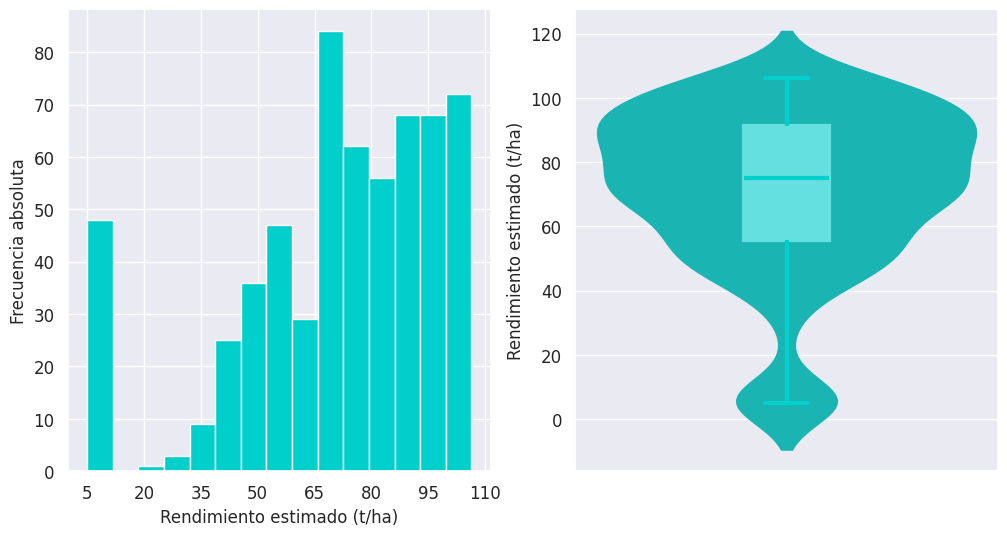

In [ ]:
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

plt.subplots(figsize=(12, 6))

# Histograma para la variable objetivo
plt.subplot(1, 2, 1)
plt.hist(xy_train_tot.loc[xy_train_tot[target_name]>5, target_name], label='Train', density=False, color =color_pal[0], bins=15)
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=12)
plt.ylabel('Frecuencia absoluta', fontsize=12)

# Establecer las marcas del eje x en intervalos de 15
min_value = int(xy_train_tot.loc[xy_train_tot[target_name]>5, target_name].min())
max_value = int(xy_train_tot.loc[xy_train_tot[target_name]>5, target_name].max())
plt.xticks(np.arange(min_value, max_value + 15, step=15).astype(int), fontsize=12)
plt.yticks(fontsize=12)
#plt.title(r'Histograma: ' + target_name.replace('_', ' ') + ' (t/ha)')

# Diagrama de violín para la variable objetivo
plt.subplot(1, 2, 2)
ax = sns.violinplot(data=xy_train_tot[xy_train_tot[target_name]>5], y=target_name, color=color_pal[0], inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')

ha = sns.boxplot(data=xy_train_tot[xy_train_tot[target_name]>5], y=target_name, width=0.2
    ,medianprops={'color':color_pal[0], 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),
    whiskerprops = dict(color=color_pal[0], linewidth=3),
    capprops = dict(color=color_pal[0], linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor=color_pal[0], markeredgecolor=color_pal[0])
    , ax=ax)

# Agregar título y nombre al eje vertical
#ax.set_title('Distribución de ' + target_name.replace('_', ' ') + ' (t/ha)')
#ax.set_title('Distribución', fontsize=12)
ax.set_ylabel(target_name.replace('_', ' ') + ' (t/ha)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
#xy_train_tot[target_name].quantile([0,0.01,0.02,0.025,0.05,0.075,0.1,0.15,0.5,0.9,0.95,0.975,0.99,1])

In [ ]:
# Aplicar función para reemplazar outliers
#xy_train_tot = replace_outliers_with_percentiles(xy_train_tot, percentile_ranges={target_name: (2, 100)})

In [ ]:
# # Visualización de variable objetivo sin outliers
# plt.subplots(figsize=(12, 6))

# # Histograma para la variable objetivo
# plt.subplot(1, 2, 1)
# plt.hist(xy_train_tot[target_name], label='Train', density=False, color =color_pal[0], bins=15)
# plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=12)

# # Establecer las marcas del eje x en intervalos de 15
# min_value = int(xy_train_tot[target_name].min())
# max_value = int(xy_train_tot[target_name].max())
# plt.xticks(np.arange(min_value, max_value + 15, step=15).astype(int), fontsize=12)
# plt.yticks(fontsize=12)
# #plt.title(r'Histograma: ' + target_name.replace('_', ' ') + ' (t/ha)')

# # Diagrama de violín para la variable objetivo
# plt.subplot(1, 2, 2)
# ax = sns.violinplot(data=xy_train_tot, y=target_name, color=color_pal[0], inner=None, linewidth=0, width=0.9)
# # ax.set_edgecolor('black')

# ha = sns.boxplot(data=xy_train_tot, y=target_name, width=0.2
#     ,medianprops={'color':color_pal[0], 'linewidth':3}
#     ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),
#     whiskerprops = dict(color=color_pal[0], linewidth=3),
#     capprops = dict(color=color_pal[0], linewidth=3)
#     ,flierprops = dict(marker='o', markersize=3,  markerfacecolor=color_pal[0], markeredgecolor=color_pal[0])
#     , ax=ax)

# # Agregar título y nombre al eje vertical
# #ax.set_title('Distribución de ' + target_name.replace('_', ' ') + ' (t/ha)')
# #ax.set_title('Distribución', fontsize=12)
# ax.set_ylabel(target_name.replace('_', ' ') + ' (t/ha)',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.show()

In [ ]:
# # Aplicar función para reemplazar outliers en training y test
# y_train_tot = replace_outliers_with_percentiles(y_train_tot, percentile_ranges={target_name: (2, 100)})
# y_test_tot = replace_outliers_with_percentiles(y_test_tot, percentile_ranges={target_name: (2, 100)})

In [ ]:
# Indicador para transformar la variable objetivo
transform_target = False
if transform_target:

  # Aplicar el logaritmo (1 + X) para corregir la asimetría
  xy_train_tot[target_name] = np.log1p(xy_train_tot[target_name])

  # Diagrama de violín para la variable objetivo
  sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

  ax = sns.violinplot(data=xy_train_tot, y=target_name, color=color_pal[0], inner=None, linewidth=0, width=0.9)
  # ax.set_edgecolor('black')
  haha = sns.boxplot(data=xy_train_tot, y=target_name, width=0.2
      ,medianprops={'color':color_pal[0], 'linewidth':3}
      ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),
      whiskerprops = dict(color=color_pal[0], linewidth=3),
      capprops = dict(color=color_pal[0], linewidth=3)
      ,flierprops = dict(marker='o', markersize=3,  markerfacecolor=color_pal[0], markeredgecolor=color_pal[0])
      , ax=ax)
  plt.show()

  # Transformar variable objetivo en train
  y_train = np.log1p(y_train_tot)

  # Transformar variable objetivo en test
  y_test = np.log1p(y_test_tot)

else:
  # Se transforma como array la variable objetivo en la base total
  xy_train_tot[target_name] = np.array(xy_train_tot[target_name])

  # Se transforma como array la variable objetivo en train
  y_train = np.array(y_train_tot)

  # Se transforma como array la variable objetivo en test
  y_test = np.array(y_test_tot)

## Gráfico de datos faltantes (missings)

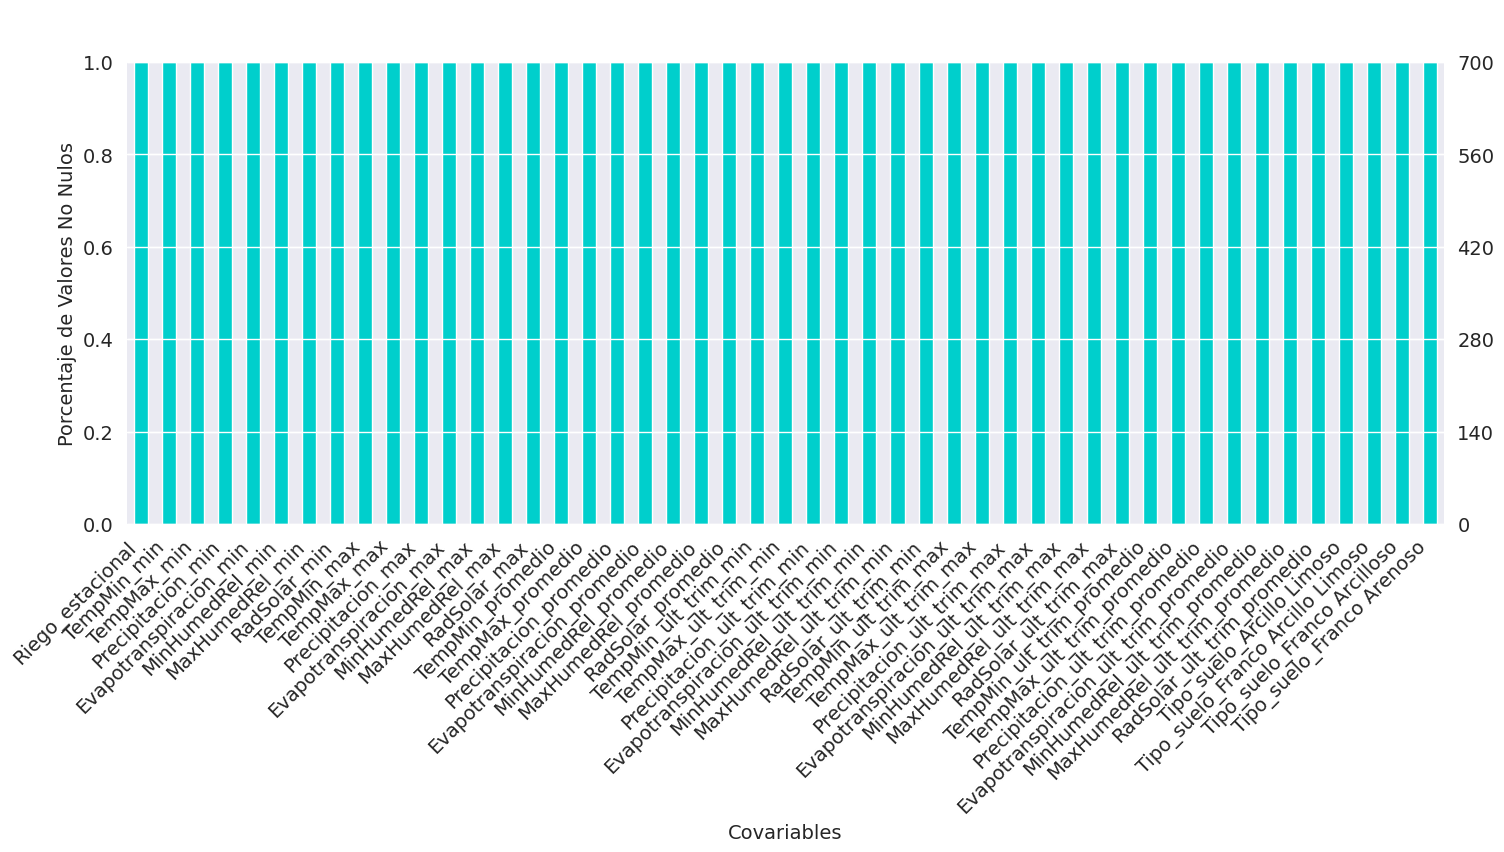

In [ ]:
# Diagrama de barras de datos faltantes y porcentaje en train
ax = msno.bar(x_train_tot, labels=True, figsize=(17,6), fontsize=14, sort="descending", color=color_pal[0])

# Asignar las etiquetas ordenadas al eje X
ax.set_xticks(range(len(features_names)))
ax.set_xticklabels(features_names, rotation=45, ha='right', fontsize=14)

# Agregar título y etiquetas de los ejes
#ax.set_title('Gráfico de barras: Datos No Nulos', fontsize=14)  # Título sugerido
ax.set_xlabel('Covariables', fontsize=14)  # Etiqueta sugerida para el eje X
ax.set_ylabel('Porcentaje de Valores No Nulos', fontsize=14)  # Etiqueta sugerida para el eje Y

#plt.axis('off')
plt.xticks(color='white', fontsize=14)
plt.yticks(color='white', fontsize=14)

# Mostrar el gráfico con las etiquetas
plt.show()

## Análisis univariado

In [ ]:
# Realizar análisis univariados (variables cuantitativas)
our_summary = full_describe(dataframe = x_train_tot, variability = 20 , completeness = 10)
our_summary

Proceso de descripción iniciado, Hora: 14:59:19
Cálculo de la función describe finalizado. Tiempo transcurrido: 0 segs
Inicio del cálculo de completitud y variabilidad, Hora: 14:59:20
Cálculo de completitud y variabilidad finalizado. Tiempo transcurrido: 0 segs
Proceso completo. Tiempo total transcurrido: 0 segs


count        mean         std         min          0%          1%          5%         10%         25%         50%          75%          90%          95%          99%         100%          max  missing  total count  % missing     variability variability_decision completeness_decision
Riego_estacional                      700.0  969.707143  496.752926  105.000000  105.000000  254.700000  450.000000  510.000000  630.000000  810.000000  1170.000000  1815.000000  2025.000000  2415.000000  2790.000000  2790.000000      0.0        700.0        0.0  high_variation               accept            accept_100
TempMin_min                           700.0   14.913143    0.871828   13.000000   13.000000   13.198000   13.600000   13.800000   14.200000   15.000000    15.400000    16.000000    16.300000    17.300000    17.300000    17.300000      0.0        700.0        0.0  high_variation               accept            accept_100
TempMax_min                           700.0   22.905571    1.288081   17.200000   17.200000   17.299000   20.500000   21.600000   22.200000   22.900000    23.900000    24.400000    24.700000    24.800000    26.200000    26.200000      0.0        700.0        0.0  high_variation               accept            accept_100
Precipitacion_min                     700.0    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      0.0        700.0        0.0    00_variation               reject            accept_100
Evapotranspiracion_min                700.0    1.527143    0.337762    0.300000    0.300000    0.498000    0.900000    1.180000    1.400000    1.500000     1.700000     2.000000     2.005000     2.100000     2.200000     2.200000      0.0        700.0        0.0  high_variation               accept            accept_100
MinHumedRel_min                       700.0   29.005714    4.234874   16.000000   16.000000   16.000000   24.000000   25.000000   27.000000   29.000000    32.000000    34.000000    36.000000    40.010000    50.000000    50.000000      0.0        700.0        0.0  high_variation               accept            accept_100
MaxHumedRel_min                       700.0   92.730000    7.047557   70.000000   70.000000   70.000000   76.900000   84.000000   91.000000   95.000000    98.000000    99.000000   100.000000   100.000000   100.000000   100.000000      0.0        700.0        0.0  high_variation               accept            accept_100
RadSolar_min                          700.0  133.983571   28.829828   66.300000   66.300000   80.500000   83.500000   91.700000  111.500000  131.400000   158.400000   166.900000   173.000000   190.217000   239.700000   239.700000      0.0        700.0        0.0  high_variation               accept            accept_100
TempMin_max                           700.0   21.130429    0.814411   16.300000   16.300000   16.500000   20.285000   20.800000   21.000000   21.200000    21.400000    21.600000    22.000000    23.500000    23.500000    23.500000      0.0        700.0        0.0  high_variation               accept            accept_100
TempMax_max                           700.0   34.451429    1.407617   25.100000   25.100000   26.700000   33.295000   33.500000   33.900000   34.600000    35.000000    35.600000    35.700000    38.300000    38.300000    38.300000      0.0        700.0        0.0  high_variation               accept            accept_100
Precipitacion_max                     700.0   63.981714   16.059275   36.100000   36.100000   37.200000   38.800000   41.500000   54.000000   64.000000    72.400000    78.800000    94.400000   117.000000   117.000000   117.000000      0.0        700.0        0.0  high_variation               accept            accept_100
Evapotranspiracion_max                700.0    7.884571    0.862303    3.700000    3.700000    4.600000    6.700000    7.000000    7.300000    7.900000     8.400000     8.900

In [ ]:
# Exportar resumen a archivo Excel en la máquina local para revisarlo
our_summary.to_excel(output_path + '/resumen_variables.xlsx', sheet_name = 'resumen')

In [ ]:
# Variables a remover de acuerdo al análisis univariado
reject_features = list(our_summary[our_summary['variability_decision'] == 'reject'].index)

In [ ]:
reject_features

['Precipitacion_min',
 'MaxHumedRel_max',
 'Precipitacion_ult_trim_min',
 'MaxHumedRel_ult_trim_max']

In [ ]:
# Covariables finales
features_names = [col for col in features_names if col not in reject_features]

## Imputación de valores faltantes

In [ ]:
# Indicador para imputar valores faltantes
impute_missing = False
if impute_missing:
  # Imputar con la "mediana" por variable
  xy_train_tot = xy_train_tot.fillna(xy_train_tot.median())
  x_train_tot = x_train_tot.fillna(x_train_tot.median())
  x_test_tot = x_test_tot.fillna(x_train_tot.median())

## Gráficos de covariables

In [ ]:
len(features_names)

43

In [ ]:
# Seleccionar la variable deseada
desired_feature = features_names[0]
desired_feature

'Riego_estacional'

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


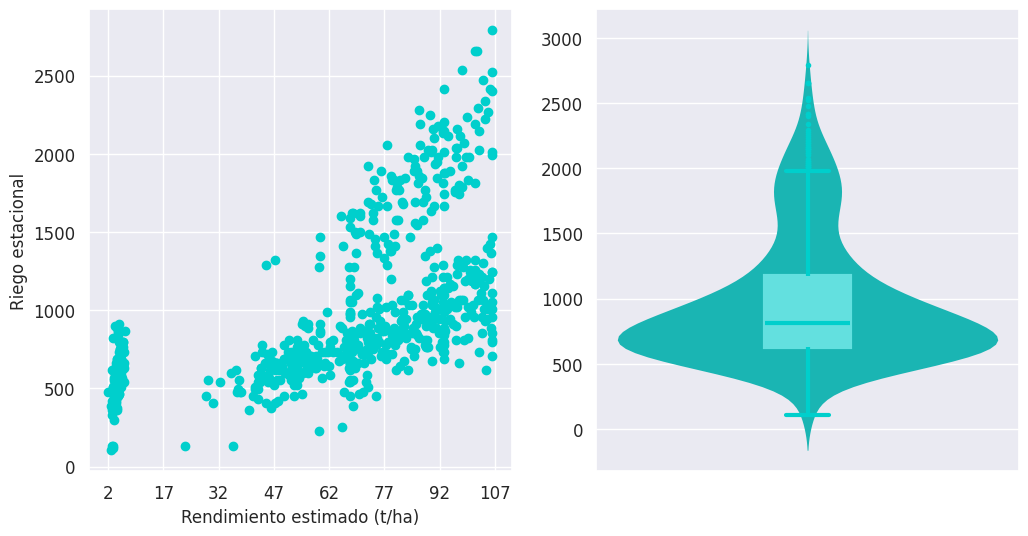

In [ ]:
plt.subplots(figsize=(12, 6))

# Calcular el gráfico de dispersión
plt.subplot(1, 2, 1)
plt.scatter(y_train, xy_train_tot[desired_feature], color=color_pal[0])
#plt.title('Gráfico de dispersión', fontsize=12)
plt.ylabel(desired_feature.replace('_', ' '), fontsize=12)
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=12)
min_x = int(y_train.min())
max_x = int(y_train.max())
plt.xticks(np.arange(min_x, max_x + 15, step=15).astype(int), fontsize=12)
plt.yticks(fontsize = 12)

# Diagrama de violín
plt.subplot(1, 2, 2)
ax = sns.violinplot(data=xy_train_tot, y=desired_feature, color=color_pal[0], inner=None, linewidth=0, width=0.9)
haha = sns.boxplot(data=xy_train_tot, y=desired_feature, width=0.2
    ,medianprops={'color':color_pal[0], 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),
    whiskerprops = dict(color=color_pal[0], linewidth=3),
    capprops = dict(color=color_pal[0], linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor=color_pal[0], markeredgecolor=color_pal[0])
    , ax=ax)
#ax.set_title('Distribución', fontsize=12)
#ax.set_ylabel(desired_feature.replace('_', ' '), fontsize=12)
ax.set_ylabel(' ', fontsize=12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

In [ ]:
#xy_train_tot[desired_feature].quantile([0,0.01,0.02,0.025,0.05,0.075,0.1,0.15,0.5,0.9,0.95,0.975,0.98,0.99,1])

In [ ]:
# Percentiles para acotar las covariables y evitar outliers

percentile_ranges = {
 'Riego_estacional': (0, 90),
 'TempMin_min': (0, 97.5),
 'TempMax_min': (5, 100),
 'Evapotranspiracion_min': (7.5, 95),
 'MinHumedRel_min': (5, 97.5),
 'MaxHumedRel_min': (10, 100),
 'RadSolar_min': (0, 99),
 'TempMin_max': (10, 90),
 'TempMax_max': (5, 95),
 'Precipitacion_max': (0, 95),
 'Evapotranspiracion_max': (2, 98),
 'MinHumedRel_max': (0, 100),
 'RadSolar_max': (5, 100),
 'TempMin_promedio': (5, 95),
 'TempMax_promedio': (2, 99),
 'Precipitacion_promedio': (0, 95),
 'Evapotranspiracion_promedio': (5, 97.5),
 'MinHumedRel_promedio': (2, 95),
 'MaxHumedRel_promedio': (15, 100),
 'RadSolar_promedio': (2, 100),
 'TempMin_ult_trim_min': (0, 100),
 'TempMax_ult_trim_min': (5, 95),
 'Evapotranspiracion_ult_trim_min': (5, 100),
 'MinHumedRel_ult_trim_min': (5, 95),
 'MaxHumedRel_ult_trim_min': (10, 100),
 'RadSolar_ult_trim_min': (0, 100),
 'TempMin_ult_trim_max': (2, 95),
 'TempMax_ult_trim_max': (5, 100),
 'Precipitacion_ult_trim_max': (0, 99),
 'Evapotranspiracion_ult_trim_max': (2, 98),#
 'MinHumedRel_ult_trim_max': (1, 95),
 'RadSolar_ult_trim_max': (1, 100),
 'TempMin_ult_trim_promedio': (7.5, 95),
 'TempMax_ult_trim_promedio': (5, 98),
 'Precipitacion_ult_trim_promedio': (0, 95),
 'Evapotranspiracion_ult_trim_promedio': (5, 95),
 'MinHumedRel_ult_trim_promedio': (5, 95),
 'MaxHumedRel_ult_trim_promedio': (15, 100),
 'RadSolar_ult_trim_promedio': (2, 100),
 'Tipo_suelo_Franco Arcilloso': (0, 100),
 'Tipo_suelo_Franco Arenoso': (0, 100),
 'Tipo_suelo_Arcillo Limoso': (0, 100),
 'Tipo_suelo_Franco Arcillo Limoso': (0, 100)
 }

In [ ]:
# Aplicar función para reemplazar outliers
x_train_tot = replace_outliers_with_percentiles(x_train_tot, percentile_ranges, features_names)
x_test_tot = replace_outliers_with_percentiles(x_test_tot, percentile_ranges, features_names)

# Conservar la base total de entrenamiento para EDA y análisis similares
xy_train_tot = pd.concat([x_train_tot,y_train_tot],axis=1)

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


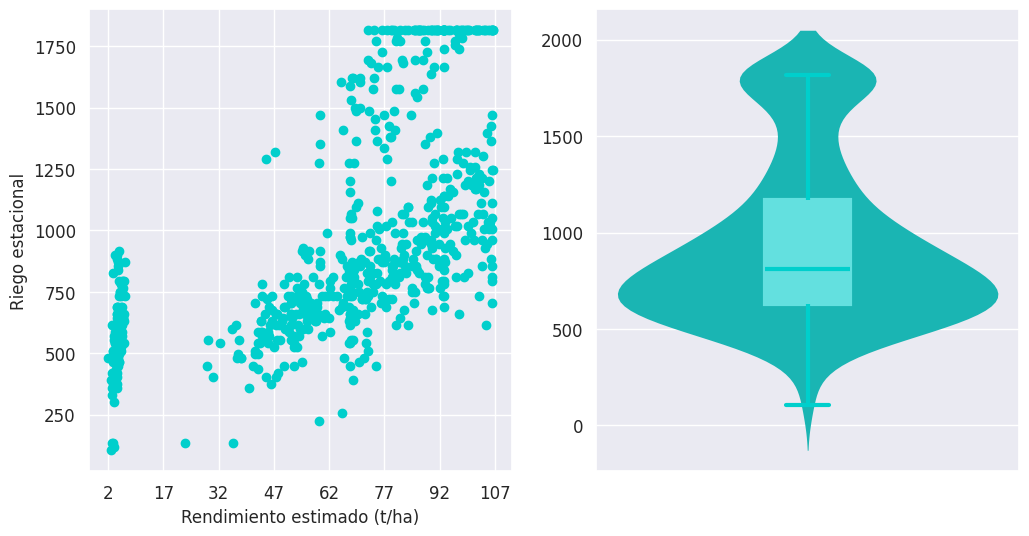

In [ ]:
# Correlación Top: 1

# Seleccionar la variable deseada
desired_feature = 'Riego_estacional'

# Visualización de covariables sin outliers
plt.subplots(figsize=(12, 6))

# Calcular el gráfico de dispersión
plt.subplot(1, 2, 1)
plt.scatter(y_train, xy_train_tot[desired_feature], color=color_pal[0])
#plt.title('Gráfico de dispersión', fontsize=12)
plt.ylabel(desired_feature.replace('_', ' '), fontsize=12)
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=12)
min_x = int(y_train.min())
max_x = int(y_train.max())
plt.xticks(np.arange(min_x, max_x + 15, step=15).astype(int), fontsize=12)
plt.yticks(fontsize = 12)

# Diagrama de violín
plt.subplot(1, 2, 2)
ax = sns.violinplot(data=xy_train_tot, y=desired_feature, color=color_pal[0], inner=None, linewidth=0, width=0.9)
haha = sns.boxplot(data=xy_train_tot, y=desired_feature, width=0.2
    ,medianprops={'color':color_pal[0], 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),
    whiskerprops = dict(color=color_pal[0], linewidth=3),
    capprops = dict(color=color_pal[0], linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor=color_pal[0], markeredgecolor=color_pal[0])
    , ax=ax)
#ax.set_title('Distribución', fontsize=12)
#ax.set_ylabel(desired_feature.replace('_', ' '), fontsize=12)
ax.set_ylabel(' ', fontsize=12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

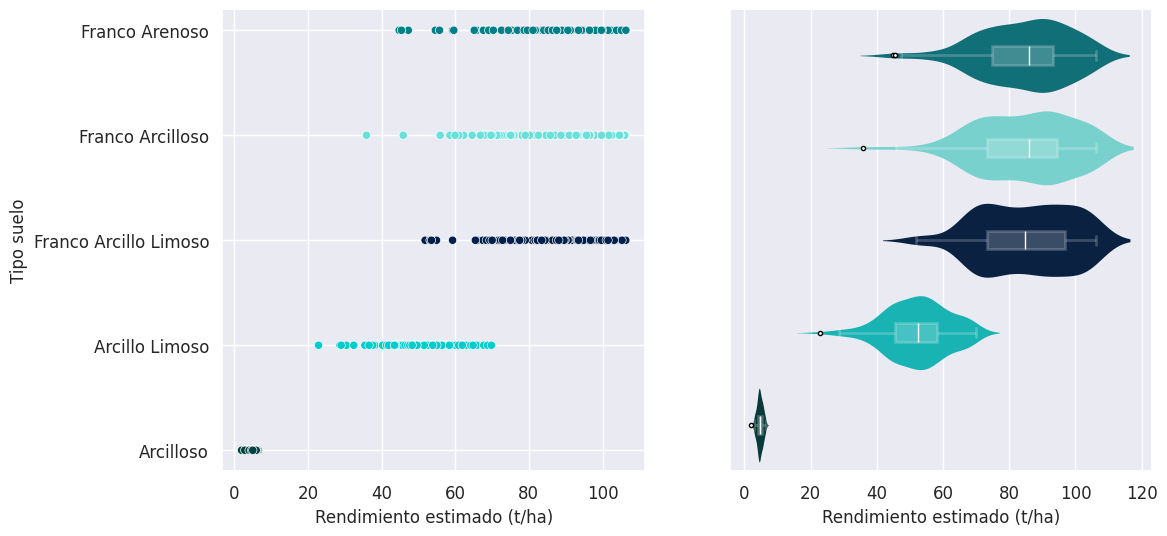

In [ ]:
# Correlación Top: 2

# Seleccionar la variable deseada
desired_feature = 'Tipo_suelo'

# Visualización de covariables sin outliers
plt.subplots(figsize=(12, 6))

# convert to a categorical variable with the categories in the "correct" order
df_suelos = data_original.loc[xy_train_tot.index].copy()
ord_labels = list(df_suelos.groupby(desired_feature)[target_name].median().sort_values(ascending=False).index)
df_suelos[desired_feature] = pd.Categorical(df_suelos[desired_feature], categories=ord_labels)

# Calcular el gráfico de dispersión
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_suelos,
                x=target_name,
                y=desired_feature,
                hue=desired_feature,
                hue_order=ord_labels,
                legend=False,
                palette=dict(zip(df_suelos['Tipo_suelo'].unique(),['#69e0da', '#00cccd', '#011f4b', '#007f88', '#004242'])))
#plt.title('Gráfico de dispersión', fontsize=12)
plt.ylabel(desired_feature.replace('_', ' '), fontsize=12)
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Diagrama de violín
plt.subplot(1, 2, 2)
ax = sns.violinplot(data=df_suelos,
                    x=target_name,
                    y=desired_feature,
                    hue=desired_feature,
                    hue_order=ord_labels,
                    legend=False,
                    palette=dict(zip(df_suelos['Tipo_suelo'].unique(),
                                     ['#69e0da', '#00cccd', '#011f4b', '#007f88', '#004242'])),
                    inner=None, linewidth=0)

sns.boxplot(data=df_suelos,
                   x=target_name,
                   y=desired_feature,
                   hue=desired_feature,
                   width=0.2
    ,medianprops=dict(color="white")
    ,boxprops=dict(zorder=1, linewidth=2, alpha=0.2, color="white")
    ,whiskerprops=dict(linewidth=2, alpha=0.2, color="white")
    ,capprops=dict(linewidth=2, alpha=0.2, color="white")
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor="white", markeredgecolor="black")
    ,palette=dict(zip(df_suelos['Tipo_suelo'].unique(),['#69e0da', '#00cccd', '#011f4b', '#007f88', '#004242']))
    ,ax=ax)
#ax.set_title('Distribución', fontsize=12)
ax.set_xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=12)
#ax.set_ylabel(desired_feature.replace('_', ' '), fontsize=12)
ax.set_ylabel('', fontsize=12)
#plt.xticks(rotation=45, ha='right', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12, visible=False)

plt.show()

In [ ]:
# # Correlación Top: 3

# # Seleccionar la variable deseada
# desired_feature = 'RadSolar_ult_trim_min'

# # Visualización de covariables sin outliers
# plt.subplots(figsize=(12, 6))

# # Calcular el gráfico de dispersión
# plt.subplot(1, 2, 1)
# plt.scatter(y_train, xy_train_tot[desired_feature], color=color_pal[0])
# #plt.title('Gráfico de dispersión', fontsize=12)
# plt.ylabel(desired_feature.replace('_', ' '), fontsize=12)
# plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=12)
# min_x = int(y_train.min())
# max_x = int(y_train.max())
# plt.xticks(np.arange(min_x, max_x + 15, step=15).astype(int), fontsize=12)
# plt.yticks(fontsize = 12)

# # Diagrama de violín
# plt.subplot(1, 2, 2)
# ax = sns.violinplot(data=xy_train_tot, y=desired_feature, color=color_pal[0], inner=None, linewidth=0, width=0.9)
# haha = sns.boxplot(data=xy_train_tot, y=desired_feature, width=0.2
#     ,medianprops={'color':color_pal[0], 'linewidth':3}
#     ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),
#     whiskerprops = dict(color=color_pal[0], linewidth=3),
#     capprops = dict(color=color_pal[0], linewidth=3)
#     ,flierprops = dict(marker='o', markersize=3,  markerfacecolor=color_pal[0], markeredgecolor=color_pal[0])
#     , ax=ax)
# #ax.set_title('Distribución', fontsize=12)
# #ax.set_ylabel(desired_feature.replace('_', ' '), fontsize=12)
# ax.set_ylabel(' ', fontsize=12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)

# plt.show()

In [ ]:
#xy_train_tot[desired_feature].quantile([0,0.01,0.02,0.025,0.05,0.075,0.1,0.15,0.5,0.9,0.95,0.975,0.98,0.99,1])

## Mapa de calor de correlación lineal (Pearson)

In [ ]:
# Gráfico de correlación de Pearson
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(xy_train_tot.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='BrBG')
#heatmap.set_title('Mapa de calor de correlación', fontdict={'fontsize':18}, pad=12)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Obtener la matriz de correlación
correlation_matrix_p = xy_train_tot.corr(method='pearson')

# Extraer las correlaciones de la variable objetivo con otras covariables
correlations_p = correlation_matrix_p[target_name].drop(target_name)  # Excluir autocorrelación

# Obtener las 12 correlaciones más altas (valores absolutos) ordenadas por orden descendente
top_12_correlations_p = correlations_p.abs().sort_values(ascending=False).head(12)
top_12_correlations_p

Riego_estacional                        0.635324
Tipo_suelo_Franco Arcillo Limoso        0.361843
Tipo_suelo_Franco Arenoso               0.343142
Tipo_suelo_Franco Arcilloso             0.304353
RadSolar_ult_trim_min                   0.187424
RadSolar_ult_trim_promedio              0.183476
Evapotranspiracion_ult_trim_min         0.165470
RadSolar_promedio                       0.164172
Tipo_suelo_Arcillo Limoso               0.150119
TempMin_ult_trim_min                    0.144975
TempMax_ult_trim_min                    0.142812
Evapotranspiracion_ult_trim_promedio    0.137837
Name: Rendimiento_estimado, dtype: float64

In [ ]:
# Obtener los nombres de las variables de las 12 correlaciones más altas
top_12_variables_p = top_12_correlations_p.index

In [ ]:
# Convertir el índice en lista y combinarlo con el nombre de la variable objetivo
columns_to_filter_p = [target_name] + list(top_12_variables_p)

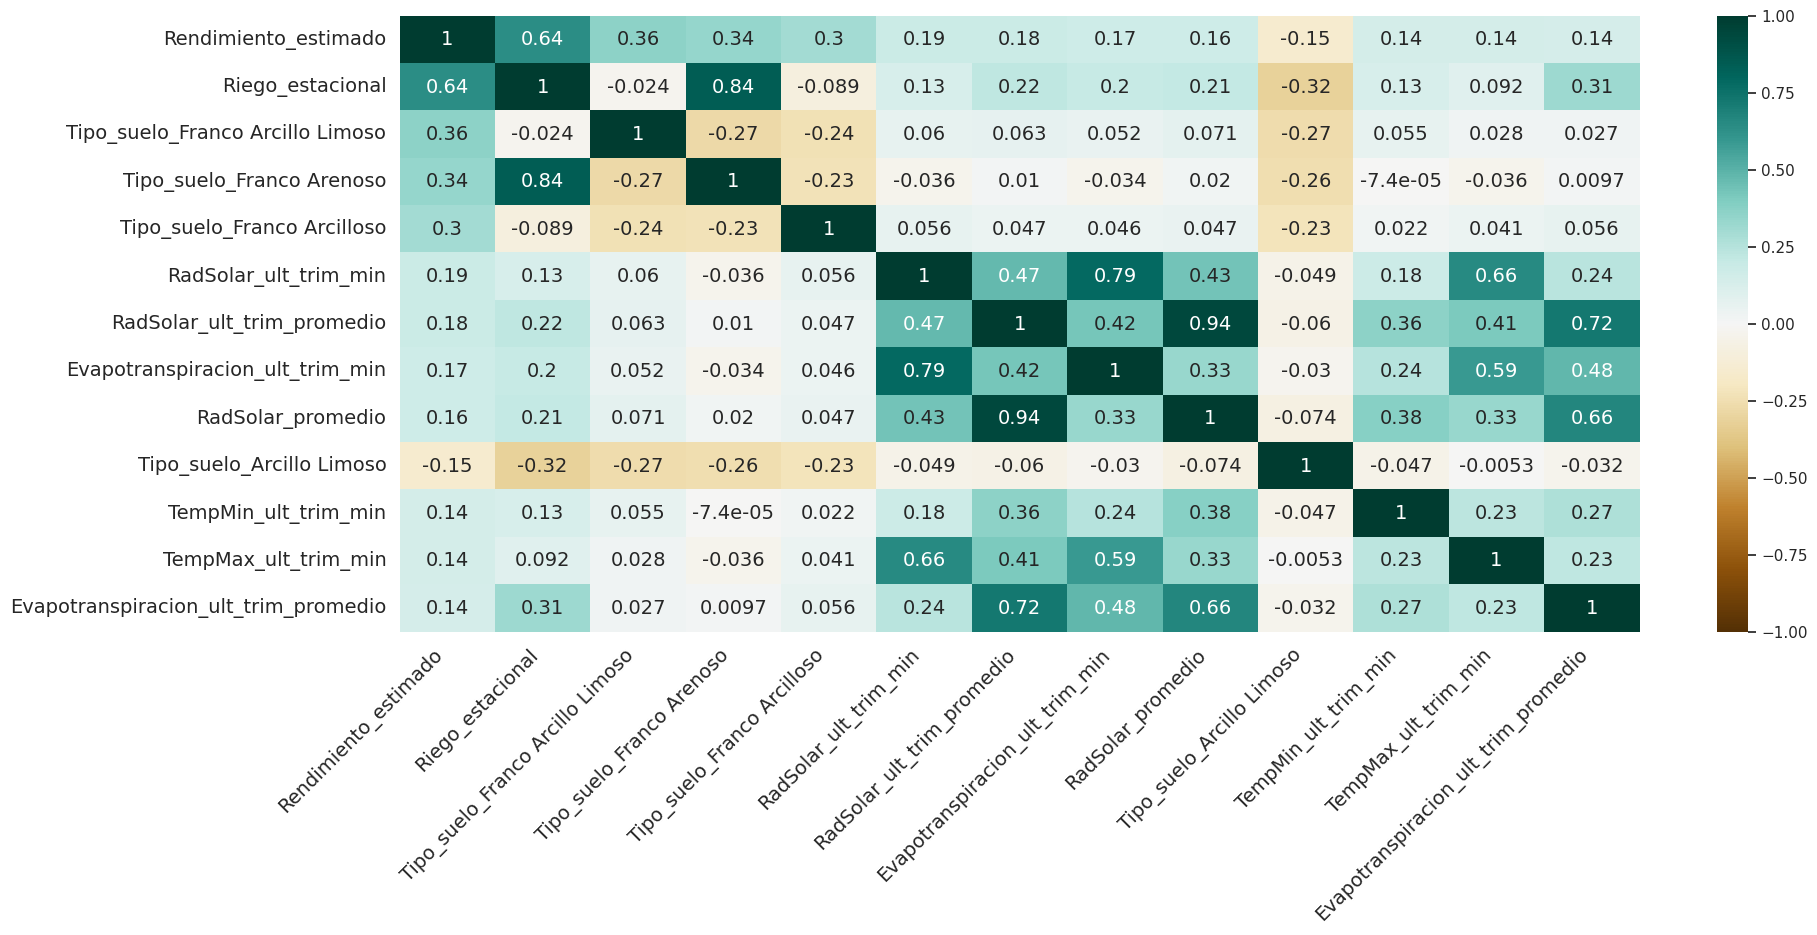

In [ ]:
# Crea un DataFrame con la variable objetivo y las 12 covariables principales
top_12_corr_df_p = xy_train_tot[columns_to_filter_p].corr(method='pearson')

# Graficar el mapa de calor
plt.figure(figsize=(20, 8))
ax = sns.heatmap(top_12_corr_df_p,  vmin=-1, vmax=1, annot=True, cmap='BrBG', annot_kws={"size": 14})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
#plt.title('Mapa de calor: Principales correlaciones con la variable objetivo', fontdict={'fontsize':18}, pad=12)
plt.show()

## Mapa de calor de correlación monótonica (Spearman)

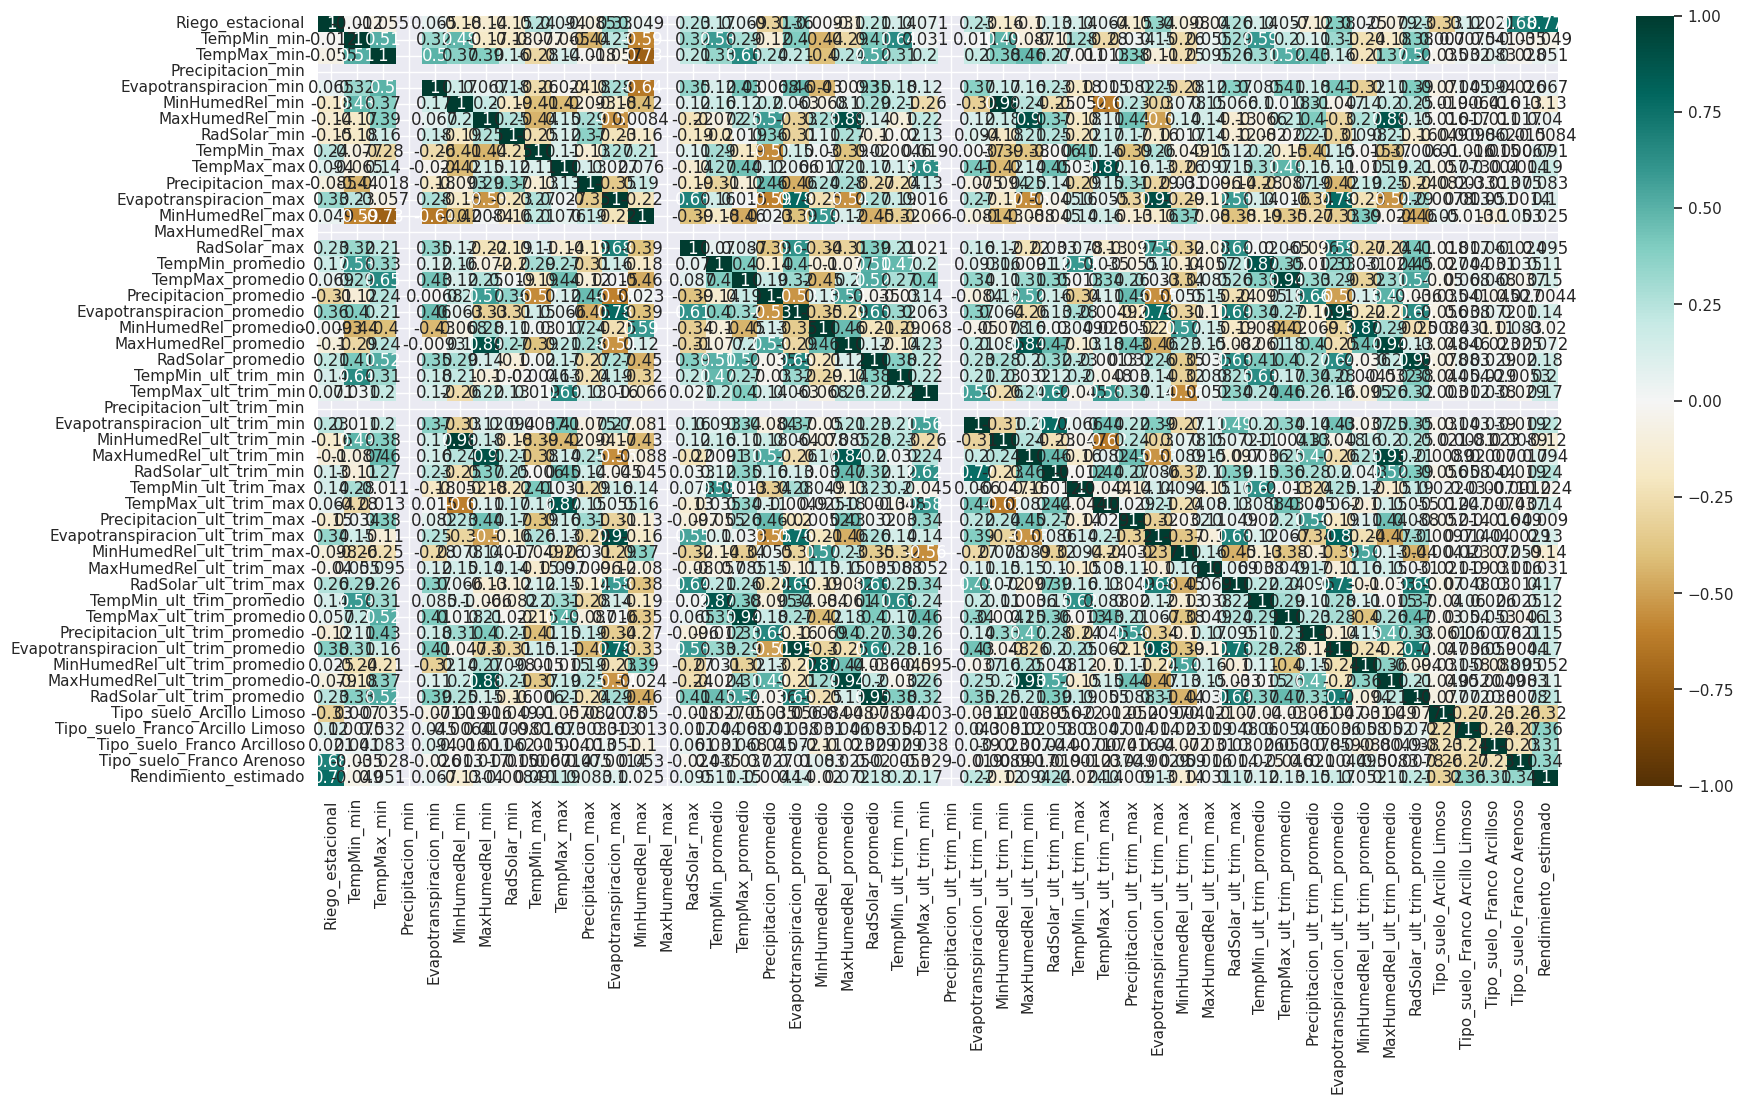

In [ ]:
# Gráfico de correlación de Pearson
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(xy_train_tot.corr(method='spearman'), vmin=-1, vmax=1, annot=True, cmap='BrBG')
#heatmap.set_title('Mapa de calor de correlación', fontdict={'fontsize':18}, pad=12)
plt.show()

In [ ]:
# Obtener la matriz de correlación
correlation_matrix_s = xy_train_tot.corr(method='spearman')

# Extraer las correlaciones de la variable objetivo con otras covariables
correlations_s = correlation_matrix_s[target_name].drop(target_name)  # Excluir autocorrelación

# Obtener las 12 correlaciones más altas (valores absolutos) ordenadas por orden descendente
top_12_correlations_s = correlations_s.abs().sort_values(ascending=False).head(12)
top_12_correlations_s

Riego_estacional                    0.766143
Tipo_suelo_Franco Arcillo Limoso    0.362639
Tipo_suelo_Franco Arenoso           0.342295
Tipo_suelo_Arcillo Limoso           0.318857
Tipo_suelo_Franco Arcilloso         0.306229
RadSolar_ult_trim_min               0.242766
Evapotranspiracion_ult_trim_min     0.222238
RadSolar_ult_trim_promedio          0.212569
TempMin_ult_trim_min                0.200705
TempMax_max                         0.186129
RadSolar_promedio                   0.177088
TempMax_ult_trim_min                0.173572
Name: Rendimiento_estimado, dtype: float64

In [ ]:
# Obtener los nombres de las variables de las 12 correlaciones más altas
top_12_variables_s = top_12_correlations_s.index

In [ ]:
# Convertir el índice en lista y combinarlo con el nombre de la variable objetivo
columns_to_filter_s = [target_name] + list(top_12_variables_s)

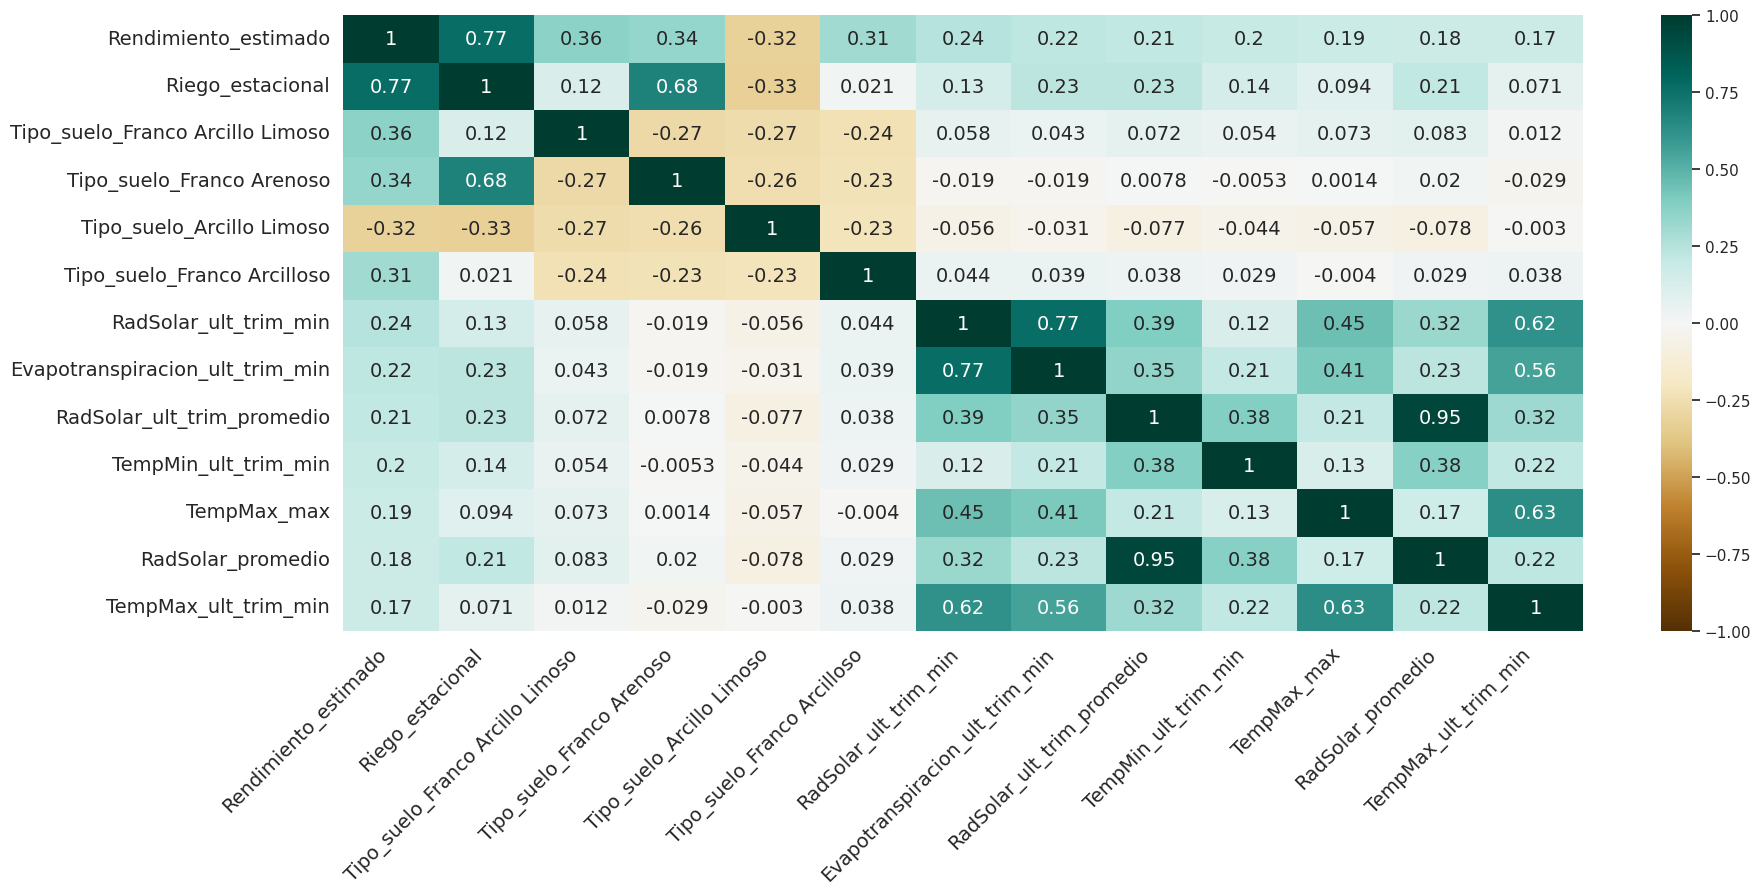

In [ ]:
# Crea un DataFrame con la variable objetivo y las 12 covariables principales
top_12_corr_df_s = xy_train_tot[columns_to_filter_s].corr(method='spearman')

# Graficar el mapa de calor
plt.figure(figsize=(20, 8))
ax = sns.heatmap(top_12_corr_df_s,  vmin=-1, vmax=1, annot=True, cmap='BrBG', annot_kws={"size": 14})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
#plt.title('Mapa de calor: Principales correlaciones con la variable objetivo', fontdict={'fontsize':18}, pad=12)
plt.show()

## Comparación de Correlaciones

In [ ]:
# Correlación Pearson
data_p = correlations_p.abs().sort_values(ascending=False)[:-3].reset_index()
data_p.rename(columns={'index':'Variable', 'Rendimiento_estimado':'Correlación Pearson'}, inplace=True)
data_p['Correlación Pearson'] = round(data_p['Correlación Pearson'],2)
string_p = pd.DataFrame(data_p.apply(lambda x: x['Variable']+': '+str(x['Correlación Pearson']), axis=1))
string_p.reset_index(drop=False, inplace=True)
string_p.rename(columns={'index':'Index Pearson', 0: 'Labels Pearson'}, inplace=True)
data_p[['Index Pearson', 'Labels Pearson']] = string_p[['Index Pearson', 'Labels Pearson']]
data_p.set_index('Variable', inplace=True)
data_p = data_p[['Labels Pearson', 'Correlación Pearson', 'Index Pearson']]
data_p.head()

Labels Pearson  Correlación Pearson  Index Pearson
Variable                                                                                                    
Riego_estacional                                  Riego_estacional: 0.64                 0.64              0
Tipo_suelo_Franco Arcillo Limoso  Tipo_suelo_Franco Arcillo Limoso: 0.36                 0.36              1
Tipo_suelo_Franco Arenoso                Tipo_suelo_Franco Arenoso: 0.34                 0.34              2
Tipo_suelo_Franco Arcilloso             Tipo_suelo_Franco Arcilloso: 0.3                 0.30              3
RadSolar_ult_trim_min                        RadSolar_ult_trim_min: 0.19                 0.19              4

In [ ]:
# Correlación Spearman
data_s = correlations_s.abs().sort_values(ascending=False)[:-3].reset_index()
data_s.rename(columns={'index':'Variable', 'Rendimiento_estimado':'Correlación Spearman'}, inplace=True)
data_s['Correlación Spearman'] = round(data_s['Correlación Spearman'],2)
string_s = pd.DataFrame(data_s.apply(lambda x: x['Variable']+': '+str(x['Correlación Spearman']), axis=1))
string_s.reset_index(drop=False, inplace=True)
string_s.rename(columns={'index':'Index Spearman', 0: 'Labels Spearman'}, inplace=True)
data_s[['Index Spearman', 'Labels Spearman']] = string_s[['Index Spearman', 'Labels Spearman']]
data_s.set_index('Variable', inplace=True)
data_s = data_s[['Labels Spearman', 'Correlación Spearman', 'Index Spearman']]
data_s.head()

Labels Spearman  Correlación Spearman  Index Spearman
Variable                                                                                                      
Riego_estacional                                  Riego_estacional: 0.77                  0.77               0
Tipo_suelo_Franco Arcillo Limoso  Tipo_suelo_Franco Arcillo Limoso: 0.36                  0.36               1
Tipo_suelo_Franco Arenoso                Tipo_suelo_Franco Arenoso: 0.34                  0.34               2
Tipo_suelo_Arcillo Limoso                Tipo_suelo_Arcillo Limoso: 0.32                  0.32               3
Tipo_suelo_Franco Arcilloso            Tipo_suelo_Franco Arcilloso: 0.31                  0.31               4

In [ ]:
# Dataframe: Top correlaciones tanto Pearson como Spearman
df_corr_fin = data_p[:13].join(data_s[:13])

labels_final = df_corr_fin['Labels Pearson'].to_list() + df_corr_fin[['Labels Spearman', 'Index Spearman']].sort_values(by=['Index Spearman'])['Labels Spearman'].to_list()

mynode = dict(
      pad = 25,
      thickness = 30,
      line = dict(color = "black", width = 1),
      label = labels_final,
      x = [0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,
           0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999],
      y = [0.001,0.027,0.027,0.029,0.031,0.033,0.035,0.038,0.048,0.050,0.053,0.057,0.120,
           0.001,0.027,0.027,0.029,0.031,0.033,0.035,0.038,0.048,0.050,0.053,0.057,0.120],
      color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf','#aec7e8','#ffbb78','#98df8a',
               '#1f77b4','#ff7f0e','#2ca02c','#bcbd22','#d62728','#9467bd','#e377c2','#8c564b','#17becf','#98df8a','#7f7f7f','#aec7e8','#ffbb78']
      )

lenght = len(df_corr_fin['Index Pearson'].to_list())

mylink = dict(
    source = df_corr_fin['Index Pearson'].to_list(),
    target = [x+lenght for x in df_corr_fin['Index Spearman'].to_list()],
    value = df_corr_fin['Correlación Spearman'].to_list())

In [ ]:
# Crear el diagrama de Sankey
fig = go.Figure(go.Sankey(
    node = mynode,
    link = mylink,
    arrangement='snap'))

cols = ["Top Correlaciones de Pearson", "Top Correlaciones de Spearman"]
for x_coordinate, column_name in enumerate(cols):
  fig.add_annotation(
          x=x_coordinate / (len(cols) - 1),
          y=1.1,
          xref="paper",
          yref="paper",
          text=column_name,
          showarrow=False,
          font=dict(
              family="Arial Black",
              size=16,
              color="black"
              ),
          align="center",
          )

fig.update_layout(
    #title_text="Basic Sankey Diagram",
    font_family="Arial Black",
    font_color="black",
    font_size=16,
    #title_font_family="Times New Roman",
    #title_font_color="red",
)

# Mostrar el diagrama
fig.show()

# Estandarizar datos

In [ ]:
# Identificador para estandarizar los datos
standardize_data = True

if standardize_data:
  # Ajusta y transforma con escalador estándar
  ss = StandardScaler()
  ss.fit(x_train_tot)

  # Guardar escalador
  with open(models_path + '/scaler_object.pkl', 'wb') as pickfile:
     pickle.dump(ss, pickfile)

  x_train_tot = pd.DataFrame(ss.transform(x_train_tot),columns = x_train_tot.columns)
  x_test_tot = pd.DataFrame(ss.transform(x_test_tot),columns = x_test_tot.columns)

# Modelación

# Aplicación de la técnica de regresión lineal múltiple

In [ ]:
# cols_lr = ['Riego_estacional',
#            'TempMin_min', 'TempMax_min',
#            'Evapotranspiracion_min', 'MinHumedRel_min', 'MaxHumedRel_min', 'RadSolar_min',
#            'TempMin_max', 'TempMax_max',
#            'Precipitacion_max', 'Evapotranspiracion_max', 'MinHumedRel_max', 'RadSolar_max',
#            'TempMin_promedio', 'TempMax_promedio', 'Precipitacion_promedio', 'Evapotranspiracion_promedio',
#            'MinHumedRel_promedio', 'MaxHumedRel_promedio', 'RadSolar_promedio',
#            'TempMin_ult_trim_min', 'TempMax_ult_trim_min',
#            'Evapotranspiracion_ult_trim_min', 'MinHumedRel_ult_trim_min', 'MaxHumedRel_ult_trim_min', 'RadSolar_ult_trim_min',
#            'TempMin_ult_trim_max',
#            'TempMax_ult_trim_max',
#            'Precipitacion_ult_trim_max', 'Evapotranspiracion_ult_trim_max', 'MinHumedRel_ult_trim_max', 'RadSolar_ult_trim_max',
#            'TempMin_ult_trim_promedio', 'TempMax_ult_trim_promedio',
#            'Precipitacion_ult_trim_promedio', 'Evapotranspiracion_ult_trim_promedio',
#            'MinHumedRel_ult_trim_promedio', 'MaxHumedRel_ult_trim_promedio', 'RadSolar_ult_trim_promedio',
#            'Tipo_suelo_Arcillo Limoso', 'Tipo_suelo_Franco Arcillo Limoso', 'Tipo_suelo_Franco Arcilloso', 'Tipo_suelo_Franco Arenoso']

In [ ]:
# Selección de variables finales

cols_lr = [
'TempMin_ult_trim_min',
'TempMin_ult_trim_max',
'TempMin_max',
'Tipo_suelo_Franco Arcillo Limoso',
'Precipitacion_max',
'Tipo_suelo_Franco Arcilloso',
'Tipo_suelo_Arcillo Limoso',
]

In [ ]:
# Filtrar los datasets con las covariables seleccionadas
x_train = x_train_tot[cols_lr]
x_test = x_test_tot[cols_lr]

# Agregue una columna completa de 1 para estimar el parámetro de intersección
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

start_time = time.time()

# Definición del modelo
model = sm.OLS(list(y_train), x_train)

# Ajuste del modelo
results = model.fit()

# Obtenga el tiempo total de entrenamiento
training_time = time.time() - start_time

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     48.37
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           6.03e-56
Time:                        15:00:05   Log-Likelihood:                -3310.9
No. Observations:                 700   AIC:                             6638.
Df Residuals:                     692   BIC:                             6674.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [ ]:
# Comprobación de supuestos

# Multicolinearidad
# Por cada covariable "X", se calcula el VIF (factor de inflación de la varianza) y se guarda el dataframe
vif = pd.DataFrame()
aux = x_train.copy()

vif["Factor VIF"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["Variable"] = aux.columns
print("======================================================================================")
print("Comprobación de multicolinealidad mediante VIF:")
print(vif.sort_values('Factor VIF',ascending=False).round(1))

# Obtener residuos
residuals = results.resid

# Independencia de errores
print("======================================================================================")
print("Comprobación de independencia de errores mediante la prueba de Durbin-Watson:")
dw_stats = sm.stats.stattools.durbin_watson(residuals, axis=0)
print("D-W statistic:", dw_stats)
if dw_stats <= 2.5 and dw_stats >= 1.5:
  print("Los residuales son independientes")
else:
  print("Los residuales NO son independientes")

# Homocedasticidad
fvalue, f_pvalue, ordering = sm.stats.diagnostic.het_goldfeldquandt(y_train, x_train)
print("======================================================================================")
print("Comprobación de homocedasticidad mediante la prueba de Goldfeld-Quandt:")
print("F-value",fvalue,"P-value", f_pvalue)
if f_pvalue >= 0.05:
  print("Los residuales son homocedásticos")
else:
  print("Los residuales NO son homocedásticos")
print("======================================================================================")

# Predecir valores de regresión con train
ypred_train = results.predict(x_train)

# Predecir valores de regresión con test
ypred_test = results.predict(x_test)

# Evaluador para NRMSE (Error cuadrático medio normalizado)
evaluator_train = RegressionMetric(list(y_train), list(ypred_train))
evaluator_test = RegressionMetric(list(y_test), list(ypred_test))

# Obtener las métricas de evaluación (RMSE, NRMSE, R2) por cada dataset
rmse_train, nrmse_train, r2_train = rmse(y_train, ypred_train), evaluator_train.normalized_root_mean_square_error(), r2_score(y_train, ypred_train)
rmse_test, nrmse_test, r2_test = rmse(y_test, ypred_test), evaluator_test.normalized_root_mean_square_error(), r2_score(y_test, ypred_test)

print("\n\nRESULTADOS FINALES: ===========================================================================================================================================================================================")
print('Train: RMSE: {:} | NRMSE: {} | R-cuadrado: {}'.format(rmse_train, nrmse_train, r2_train))
print('Test: RMSE: {:} | NRMSE: {} | R-cuadrado: {}'.format(rmse_test, nrmse_test, r2_test))
print("Tiempo de entrenamiento: %s segundos" % (training_time))

# Cálculo de la importancia de las covariables
lr = LinearRegression()
lr.fit(x_train, y_train)
imps = permutation_importance(lr, x_train, y_train)

# Crear dataframe con la importancia de las covariables
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["Variable","Importancia"]

importance = importance.sort_values(by='Importancia', ascending=False)
print("======================================================================================")
print("Importancia de las variables:")
print(importance)

Comprobación de multicolinealidad mediante VIF:
   Factor VIF                          Variable
2         1.5              TempMin_ult_trim_max
3         1.4                       TempMin_max
4         1.2  Tipo_suelo_Franco Arcillo Limoso
7         1.2         Tipo_suelo_Arcillo Limoso
6         1.2       Tipo_suelo_Franco Arcilloso
5         1.1                 Precipitacion_max
1         1.1              TempMin_ult_trim_min
0         1.0                             const
Comprobación de independencia de errores mediante la prueba de Durbin-Watson:
D-W statistic: 2.15269283062604
Los residuales son independientes
Comprobación de homocedasticidad mediante la prueba de Goldfeld-Quandt:
F-value 0.9244936906199117 P-value 0.7658721125895911
Los residuales son homocedásticos


RESULTADOS FINALES: ===========================================================================================================================================================================================
Train:

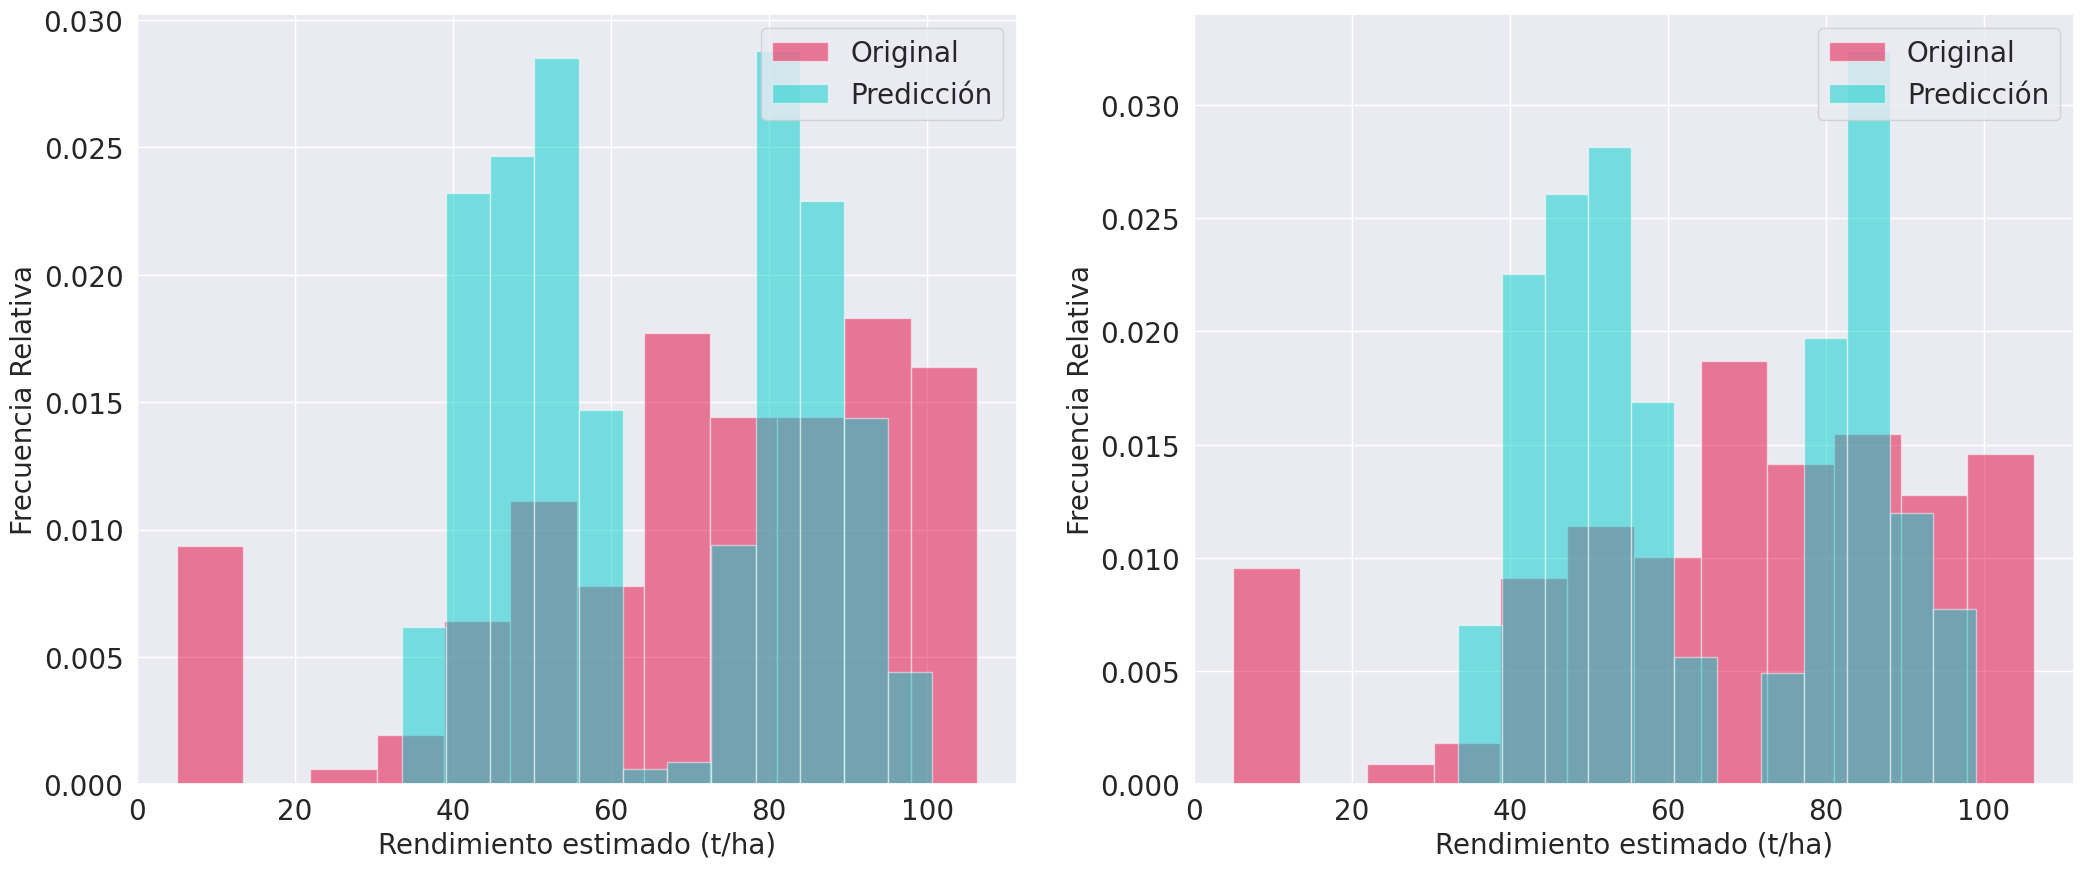

In [ ]:
# Obtener valores para graficar
if transform_target:
  target_train_orig = np.expm1(target_train_orig)
  target_test_orig = np.expm1(y_test)

  target_train_pred = np.expm1(ypred_train)
  target_test_pred = np.expm1(ypred_test)
else:
  target_train_orig = y_train
  target_test_orig = y_test

  target_train_pred = ypred_train
  target_test_pred = ypred_test

# Visualización de resultados
f, axs = plt.subplots(1,1,figsize=(25,10))
axs.tick_params(axis='both', labelsize=20)

plt.subplot(1, 2, 1)
plt.hist(target_train_orig[target_train_orig>5],alpha = 0.5, label='Original', density=True, bins = 12, color=color_pal[1])
plt.hist(target_train_pred[target_train_orig>5],alpha = 0.5, label='Predicción', density=True, bins = 12, color = color_pal[0])
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=20)
plt.ylabel('Frecuencia Relativa', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
#plt.title(r'Histograma de datos de entrenamiento (Train)', fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.subplot(1, 2, 2)
plt.hist(target_test_orig[target_test_orig>5],alpha = 0.5, label='Original', density=True, bins = 12, color=color_pal[1])
plt.hist(target_test_pred[target_test_orig>5],alpha = 0.5, label='Predicción', density=True, bins = 12, color = color_pal[0])
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=20)
plt.ylabel('Frecuencia Relativa', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
#plt.title(r'Histograma de datos de prueba (Test)', fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

In [ ]:
# Definir métricas en un dataframe
metrics_lr = {'metric_name':  ['RMSE', 'RMSE', 'NRMSE', 'NRMSE', 'R-cuadrado', 'R-cuadrado'],
           'set_used': ['Train', 'Test', 'Train', 'Test', 'Train', 'Test'],
           'metric_value': [rmse_train, rmse_test
           ,nrmse_train, nrmse_test
           ,r2_train, r2_test]
        }

metrics_lr = pd.DataFrame(metrics_lr, columns = ['metric_name', 'set_used','metric_value'])

# Graficos de las métricas
fig = go.Figure(data=[
    go.Bar(name='Entrenamiento', x=metrics_lr[metrics_lr['set_used']=="Train"]['metric_name'], y=metrics_lr[metrics_lr['set_used']=="Train"]['metric_value'], marker_color=color_pal[2]),
    go.Bar(name='Prueba', x=metrics_lr[metrics_lr['set_used']=="Test"]['metric_name'], y=metrics_lr[metrics_lr['set_used']=="Test"]['metric_value'], marker_color=color_pal[3]),
], layout_yaxis_range=[0,metrics_lr['metric_value'].max()+1])

# Agregar una línea discontinua horizontal en y=1
fig.add_shape(
    type='line',
    x0=-0.5,  # Comienza justo antes de la primera barra
    x1=len(metrics_lr['metric_name'].unique()) - 0.5,  # Termina justo después de la última barra
    y0=1,
    y1=1,
    line=dict(color='Black', width=2, dash='dash')  # Personaliza el color, el ancho y el estilo de la línea
)

fig.update_layout(barmode='group', autosize=False,
    width=700,
    height=500, xaxis_title="Métricas",
    yaxis_title="Valor de evaluación",
    legend_title="Datos", font=dict(size=16)
    )

fig.show()

# Guardar tiempo de entrenamiento en un dataframe
time_measure_lr = {'measure_name':  ['Time'],
           'measure_value': [training_time]
        }

time_measure_lr = pd.DataFrame(time_measure_lr, columns = ['measure_name','measure_value'])

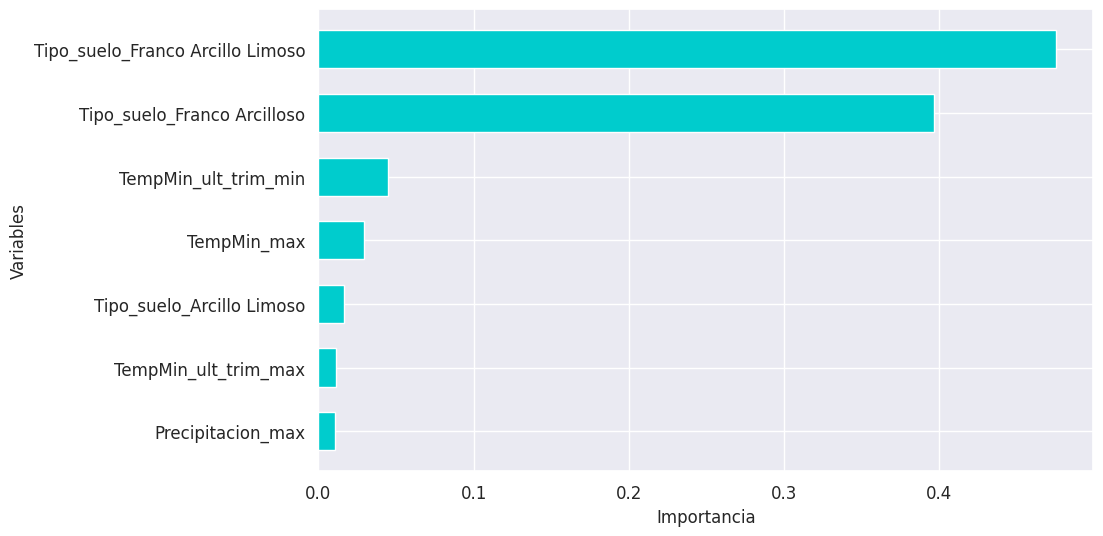

In [ ]:
# Ordenar el dataframe por valores de importancia en orden descendente
lr_importance = importance.iloc[:-1].copy()
#lr_importance = importance.copy()

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(lr_importance['Variable'], lr_importance['Importancia'], color=color_pal[3], height=0.6)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variables', fontsize=12)
#plt.title('Regresión lineal múltiple', fontsize=12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.gca().invert_yaxis()  # Invierta el eje y para mostrar la mayor importancia en la parte superior
plt.show()

# Aplicación de la técnica XGBoost

In [ ]:
# cols_xgb = ['Riego_estacional',
#            'TempMin_min', 'TempMax_min',
#            'Evapotranspiracion_min', 'MinHumedRel_min', 'MaxHumedRel_min', 'RadSolar_min',
#            'TempMin_max', 'TempMax_max',
#            'Precipitacion_max', 'Evapotranspiracion_max', 'MinHumedRel_max', 'RadSolar_max',
#            'TempMin_promedio', 'TempMax_promedio', 'Precipitacion_promedio', 'Evapotranspiracion_promedio',
#            'MinHumedRel_promedio', 'MaxHumedRel_promedio', 'RadSolar_promedio',
#            'TempMin_ult_trim_min', 'TempMax_ult_trim_min',
#            'Evapotranspiracion_ult_trim_min', 'MinHumedRel_ult_trim_min', 'MaxHumedRel_ult_trim_min', 'RadSolar_ult_trim_min',
#            'TempMin_ult_trim_max',
#            'TempMax_ult_trim_max',
#            'Precipitacion_ult_trim_max', 'Evapotranspiracion_ult_trim_max', 'MinHumedRel_ult_trim_max', 'RadSolar_ult_trim_max',
#            'TempMin_ult_trim_promedio', 'TempMax_ult_trim_promedio',
#            'Precipitacion_ult_trim_promedio', 'Evapotranspiracion_ult_trim_promedio',
#            'MinHumedRel_ult_trim_promedio', 'MaxHumedRel_ult_trim_promedio', 'RadSolar_ult_trim_promedio',
#            'Tipo_suelo_Arcillo Limoso', 'Tipo_suelo_Franco Arcillo Limoso', 'Tipo_suelo_Franco Arcilloso', 'Tipo_suelo_Franco Arenoso']

In [ ]:
# Selección de variables finales

cols_xgb = [
'Riego_estacional',
'Tipo_suelo_Franco Arcilloso',
'Tipo_suelo_Franco Arcillo Limoso',
'Tipo_suelo_Arcillo Limoso',
'Precipitacion_promedio',
'Tipo_suelo_Franco Arenoso',
'Precipitacion_ult_trim_promedio',
'TempMin_ult_trim_min',
'Evapotranspiracion_max'
]

In [ ]:
# Filtrar los datasets con las covariables seleccionadas
x_train = x_train_tot[cols_xgb]
x_test = x_test_tot[cols_xgb]

In [ ]:
# Definir parámetros para el fine-tuning
num_folds = 5
kf = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

In [ ]:
# Ajustar indicador para entrenar o cargar modelo
# Para cargar un modelo: load_model = True
# Para entrenar un modelo: load_model = False
load_model = False

print("======================================================================================")
print("X Train dimensión:",x_train.shape)
print("Y Train dimensión:",y_train.shape)
print("X Test dimensión:",x_test.shape)
print("Y Test dimensión:",y_test.shape)

# Imprimir hiperparámetros óptimos
if load_model:
  # Cargar modelo
  infile = open(models_path + '/XGboost_model.pkl','rb')
  xgb_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_XGboost.pkl','rb')
  best_params = pickle.load(infile)
  infile = open(models_path + '/train_time_model_XGboost.pkl','rb')
  training_time = pickle.load(infile)
else:
  start_time = time.time()

  # Definir función a minimizar
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):

      # Usar parámetros para entrenar el modelo
      model = make_pipeline( XGBRegressor(random_state = random_state, **params))

      # Validación cruzada
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Definir grilla
  parameters = {'max_depth': hp.choice('max_depth', range(3,10,1))
        , 'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1)
        , 'n_estimators': hp.choice('n_estimators', [300])
        , 'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1)
        , 'reg_alpha' : hp.quniform('reg_alpha', 0,1,1)
        # , 'reg_lambda' : hp.uniform('reg_lambda', 0,1)
        # , 'gamma': hp.uniform ('gamma', 0,0.5)
    }

  # Minimizar función
  best = fmin(fn = param_selection_cv
            , space = parameters
            , algo = tpe.suggest
            , max_evals = 10
            , rstate = np.random.default_rng(random_state)
          )

  # Devuelve los mejores hiperparámetros
  best_params = space_eval(parameters, best)

  # Definir modelo con los mejores hiperparámetros
  xgb_grid = make_pipeline( XGBRegressor(random_state = random_state, **best_params))

  # Entrenar modelo
  xgb_grid.fit(x_train,y_train)

  # Obtener tiempo total de entrenamiento
  training_time = time.time() - start_time

  # Guardar modelo
  with open(models_path + '/XGboost_model.pkl', 'wb') as pickfile:
     pickle.dump(xgb_grid, pickfile)
  with open(models_path + '/best_params_XGboost.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
  with open(models_path + '/train_time_model_XGboost.pkl', 'wb') as pickfile:
    pickle.dump(training_time, pickfile)

print("======================================================================================")
print("Mejores parámetros: ")
print(best_params)
print("======================================================================================")

# Predecir valores de regresión con train
ypred_train = xgb_grid.predict(x_train)

# Predecir valores de regresión con test
ypred_test = xgb_grid.predict(x_test)

# Evaluador para NRMSE (Error cuadrático medio normalizado)
evaluator_train = RegressionMetric(list(y_train), list(ypred_train))
evaluator_test = RegressionMetric(list(y_test), list(ypred_test))

# Obtener las métricas de evaluación (RMSE, NRMSE, R2) por cada dataset
rmse_train, nrmse_train, r2_train = rmse(y_train, ypred_train), evaluator_train.normalized_root_mean_square_error(), r2_score(y_train, ypred_train)
rmse_test, nrmse_test, r2_test = rmse(y_test, ypred_test), evaluator_test.normalized_root_mean_square_error(), r2_score(y_test, ypred_test)

print("\n\nRESULTADOS FINALES: ===========================================================================================================================================================================================")
print('Train: RMSE: {:} | NRMSE: {} | R-cuadrado: {}'.format(rmse_train, nrmse_train, r2_train))
print('Test: RMSE: {:} | NRMSE: {} | R-cuadrado: {}'.format(rmse_test, nrmse_test, r2_test))
print("Tiempo de entrenamiento: %s segundos" % (training_time))

# Cálculo de la importancia de las covariables
imps = permutation_importance(xgb_grid, x_train, y_train)

# Crear dataframe con la importancia de las covariables
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["Variable","Importancia"]

importance = importance.sort_values(by='Importancia', ascending=False)
print("======================================================================================")
print("Importancia de las variables:")
print(importance)

X Train dimensión: (700, 9)
Y Train dimensión: (700,)
X Test dimensión: (300, 9)
Y Test dimensión: (300,)
100%|██████████| 10/10 [00:14<00:00,  1.42s/trial, best loss: 5.624056941481973]
Mejores parámetros: 
{'colsample_bytree': 0.8627757831719449, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 300, 'reg_alpha': 1.0}


RESULTADOS FINALES: ===========================================================================================================================================================================================
Train: RMSE: 1.4744513482883712 | NRMSE: 0.04422594833043726 | R-cuadrado: 0.9980568215059576
Test: RMSE: 7.183463831478603 | NRMSE: 0.2339570122022228 | R-cuadrado: 0.9521888643783535
Tiempo de entrenamiento: 14.31845998764038 segundos
Importancia de las variables:
                           Variable  Importancia
0                  Riego_estacional     0.919352
2  Tipo_suelo_Franco Arcillo Limoso     0.544541
1       Tipo_suelo_Franco Arcilloso     0.52799

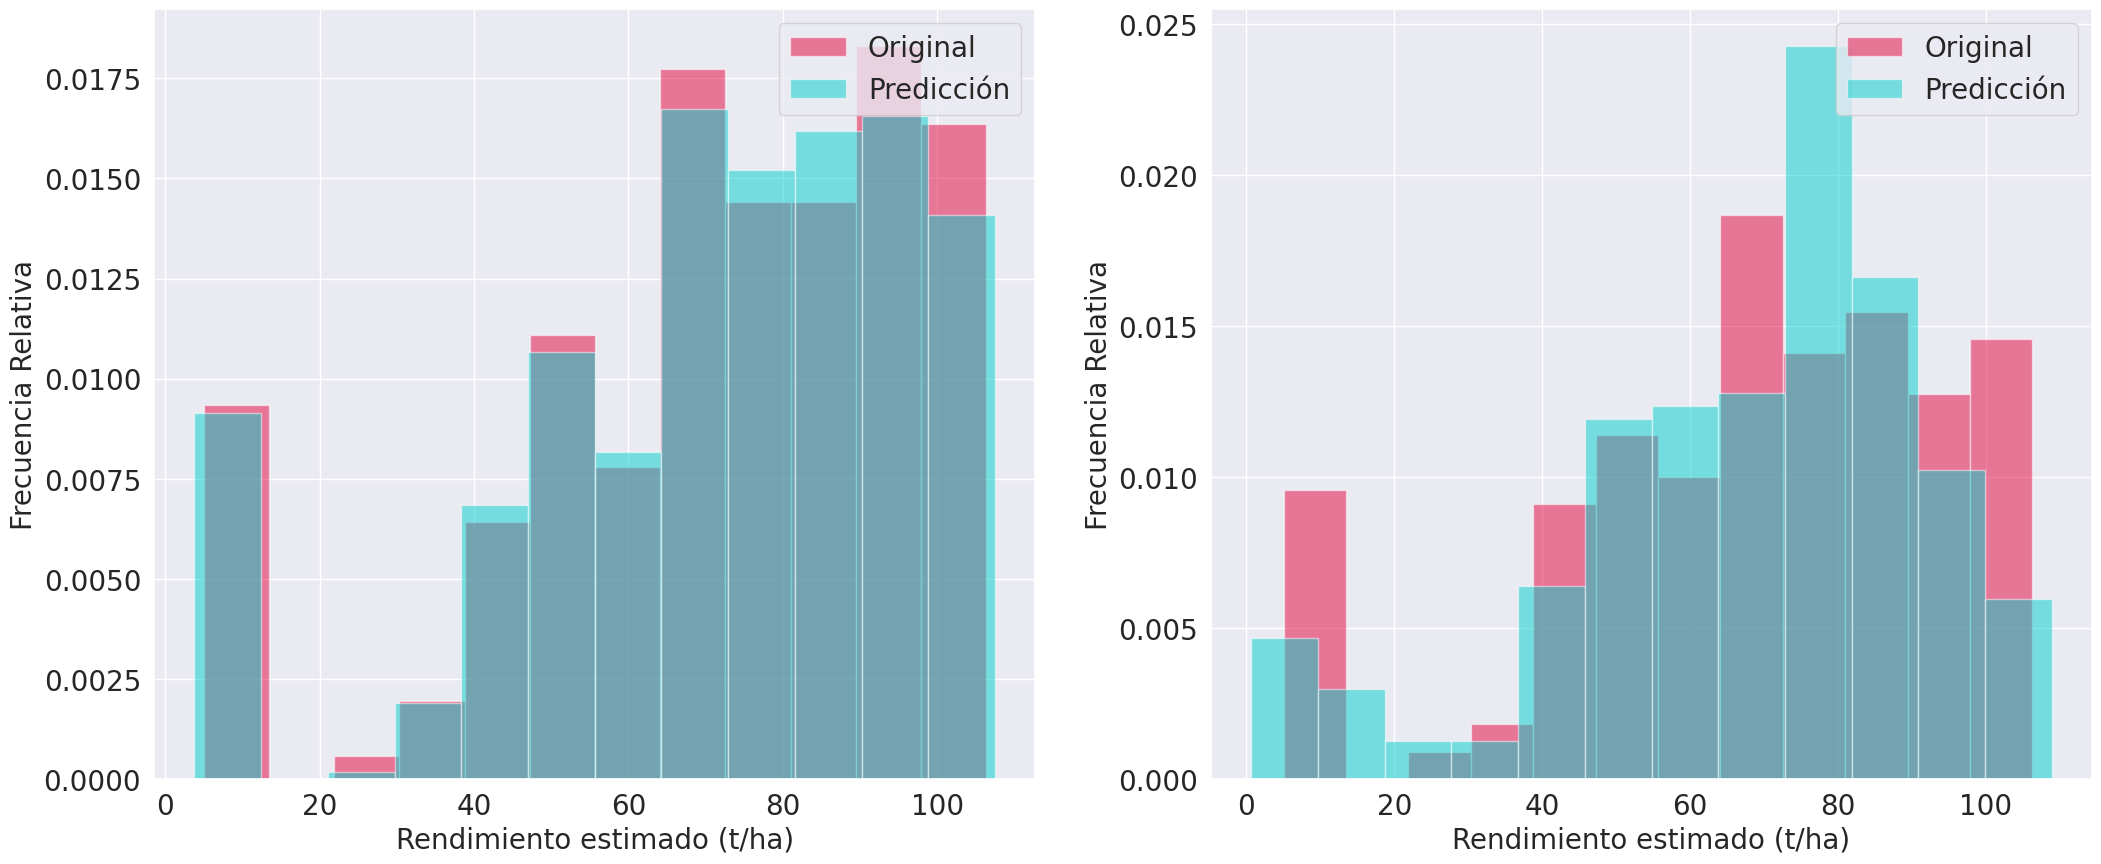

In [ ]:
# Obtener valores para graficar
if transform_target:
  target_train_orig = np.expm1(y_train)
  target_test_orig = np.expm1(y_test)

  target_train_pred = np.expm1(ypred_train)
  target_test_pred = np.expm1(ypred_test)
else:
  target_train_orig = y_train
  target_test_orig = y_test

  target_train_pred = ypred_train
  target_test_pred = ypred_test

# Visualización de resultados
f, axs = plt.subplots(1,1,figsize=(25,10))
axs.tick_params(axis='both', labelsize=20)

plt.subplot(1, 2, 1)
plt.hist(target_train_orig[target_train_orig>5],alpha = 0.5, label='Original', density=True, bins = 12, color=color_pal[1])
plt.hist(target_train_pred[target_train_orig>5],alpha = 0.5, label='Predicción', density=True, bins = 12, color = color_pal[0])
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=20)
plt.ylabel('Frecuencia Relativa', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
#plt.title(r'Histograma de datos de entrenamiento (Train)', fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.subplot(1, 2, 2)
plt.hist(target_test_orig[target_test_orig>5],alpha = 0.5, label='Original', density=True, bins = 12, color=color_pal[1])
plt.hist(target_test_pred[target_test_orig>5],alpha = 0.5, label='Predicción', density=True, bins = 12, color = color_pal[0])
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=20)
plt.ylabel('Frecuencia Relativa', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
#plt.title(r'Histograma de datos de prueba (Test)', fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

In [ ]:
# Definir métricas en un dataframe
metrics_xgb = {'metric_name':  ['RMSE', 'RMSE', 'NRMSE', 'NRMSE', 'R-cuadrado', 'R-cuadrado'],
           'set_used': ['Train', 'Test', 'Train', 'Test', 'Train', 'Test'],
           'metric_value': [rmse_train, rmse_test
           ,nrmse_train, nrmse_test
           ,r2_train, r2_test]
        }

metrics_xgb = pd.DataFrame(metrics_xgb, columns = ['metric_name', 'set_used','metric_value'])

# Graficos de las métricas
fig = go.Figure(data=[
    go.Bar(name='Entrenamiento', x=metrics_xgb[metrics_xgb['set_used']=="Train"]['metric_name'], y=metrics_xgb[metrics_xgb['set_used']=="Train"]['metric_value'], marker_color=color_pal[2]),
    go.Bar(name='Prueba', x=metrics_xgb[metrics_xgb['set_used']=="Test"]['metric_name'], y=metrics_xgb[metrics_xgb['set_used']=="Test"]['metric_value'], marker_color=color_pal[3]),
], layout_yaxis_range=[0,metrics_xgb['metric_value'].max()+1])

# Agregar una línea discontinua horizontal en y=1
fig.add_shape(
    type='line',
    x0=-0.5,  # Comienza justo antes de la primera barra
    x1=len(metrics_xgb['metric_name'].unique()) - 0.5,  # Termina justo después de la última barra
    y0=1,
    y1=1,
    line=dict(color='Black', width=2, dash='dash')  # Personaliza el color, el ancho y el estilo de la línea
)

fig.update_layout(barmode='group', autosize=False,
    width=700,
    height=500, xaxis_title="Métricas",
    yaxis_title="Valor de evaluación",
    legend_title="Datos", font=dict(size=16)
    )

fig.show()

# Guardar tiempo de entrenamiento en un dataframe
time_measure_xgb = {'measure_name':  ['Time'],
           'measure_value': [training_time]
        }

time_measure_xgb = pd.DataFrame(time_measure_xgb, columns = ['measure_name','measure_value'])

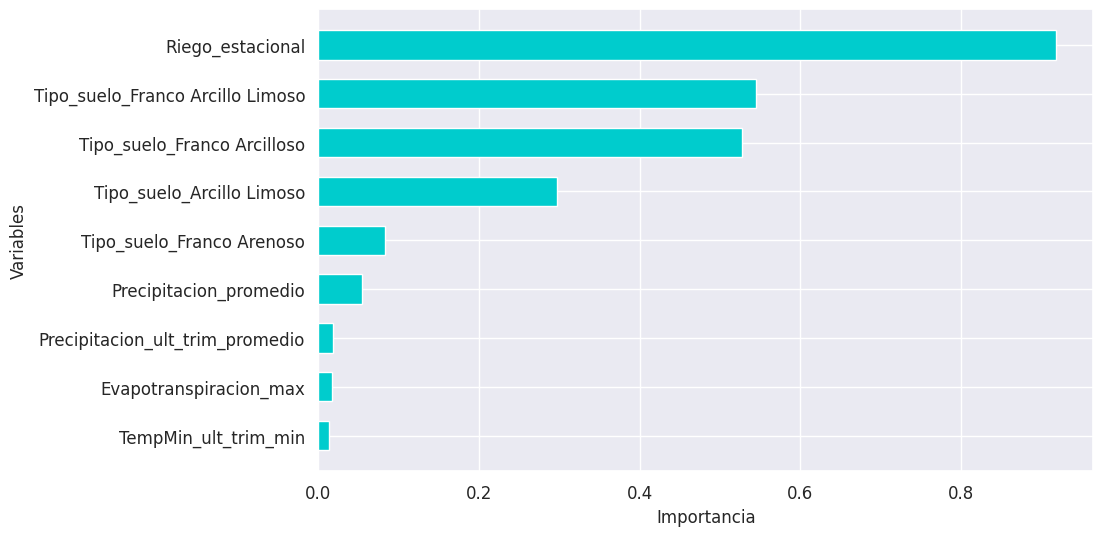

In [ ]:
# Ordenar el dataframe por valores de importancia en orden descendente
xgb_importance = importance.copy()

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(xgb_importance['Variable'], xgb_importance['Importancia'], color=color_pal[3], height=0.6)
plt.xlabel('Importancia', fontsize = 12)
plt.ylabel('Variables', fontsize = 12)
#plt.title('XGBoost', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.gca().invert_yaxis()  # Invierta el eje y para mostrar la mayor importancia en la parte superior
plt.show()

# Explicabilidad de las variables (Interpretabilidad)

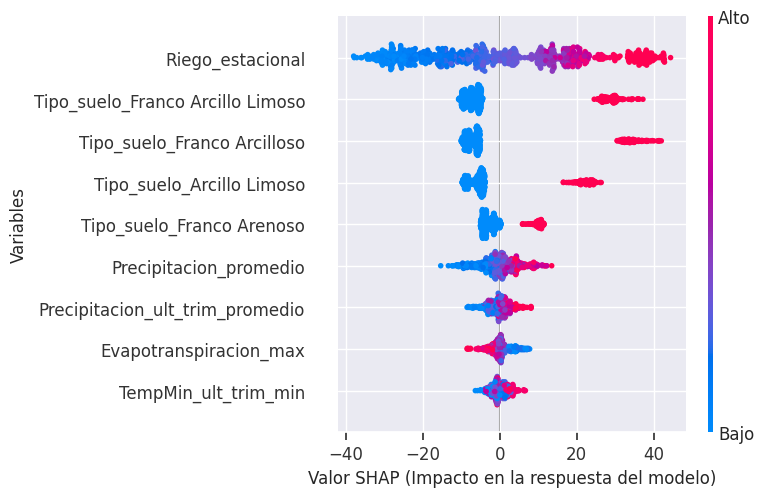

In [ ]:
# Definir objeto SHAP
explainer = shap.TreeExplainer(xgb_grid.named_steps['xgbregressor'])
shap_values = explainer.shap_values(x_train)

# Graficar efecto de las variables
shap.summary_plot(shap_values, x_train, show=False)

# Obtener la figura y los ejes actuales
fig = plt.gcf()
ax = plt.gca()

# Personalizar las etiquetas de los ejes
if len(fig.axes) > 1:
    cbar_ax = fig.axes[-1]
    cbar_ax.set_ylabel('', rotation=90, labelpad=20)
    cbar_ax.set_yticklabels(['Bajo', 'Alto'], fontsize=12)

# Modificar los ejes
ax.set_xlabel('Valor SHAP (Impacto en la respuesta del modelo)', fontsize=12)
ax.set_ylabel('Variables', fontsize=12)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Mostrar el gráfico
plt.show()

In [ ]:
# Extraer el modelo XGBoost entrenado
xgb_model = xgb_grid.named_steps['xgbregressor']

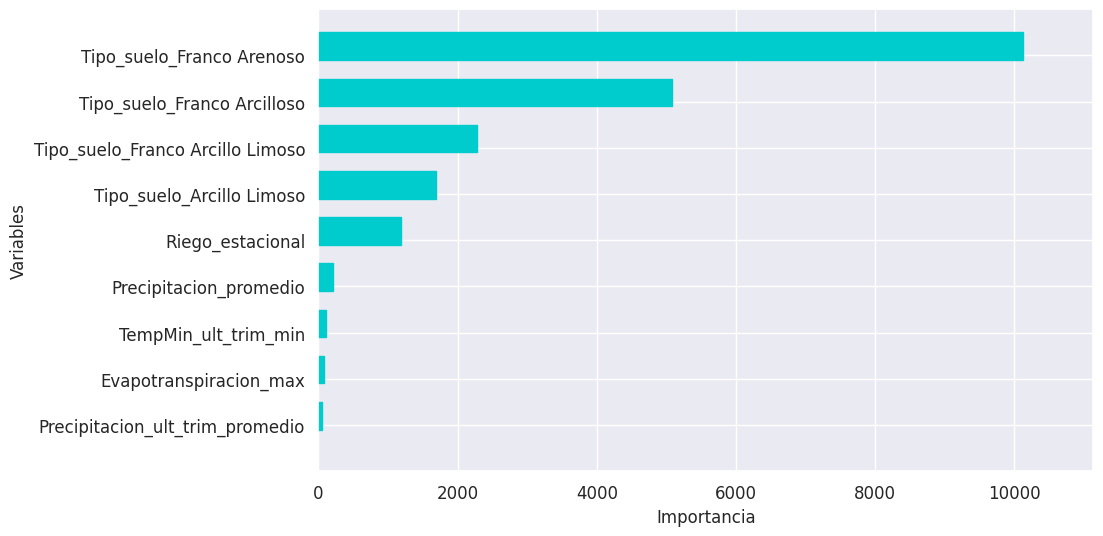

In [ ]:
# Crea una figura y ejes con el tamaño deseado
fig, ax = plt.subplots(figsize=(10, 6))  # Ajuste el ancho y la altura (en pulgadas) según sea necesario

# Visualizar el gráfico de importancia propio del modelo
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=20, ax=ax)

# Eliminar las anotaciones de texto de las barras que tiene por default
for text in ax.texts:
    text.set_visible(False)

# Cambiar el color de las barras
for bar in ax.patches:
    bar.set_color(color_pal[3])
    bar.set_height(0.6)  # Ajustar este valor para hacer las barras más gruesas (el valor predeterminado es alrededor de 0,6)

# Establecer la etiqueta del eje "x" y del eje "y"
ax.set_xlabel('Importancia', fontsize=12) #F-Score
ax.set_ylabel('Variables', fontsize=12)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Visualizar la importancia de las variables
plt.title("")
plt.show()

# Aplicación de la técnica Random Forest

In [ ]:
# cols_rf = ['Riego_estacional',
#            'TempMin_min', 'TempMax_min',
#            'Evapotranspiracion_min', 'MinHumedRel_min', 'MaxHumedRel_min', 'RadSolar_min',
#            'TempMin_max', 'TempMax_max',
#            'Precipitacion_max', 'Evapotranspiracion_max', 'MinHumedRel_max', 'RadSolar_max',
#            'TempMin_promedio', 'TempMax_promedio', 'Precipitacion_promedio', 'Evapotranspiracion_promedio',
#            'MinHumedRel_promedio', 'MaxHumedRel_promedio', 'RadSolar_promedio',
#            'TempMin_ult_trim_min', 'TempMax_ult_trim_min',
#            'Evapotranspiracion_ult_trim_min', 'MinHumedRel_ult_trim_min', 'MaxHumedRel_ult_trim_min', 'RadSolar_ult_trim_min',
#            'TempMin_ult_trim_max',
#            'TempMax_ult_trim_max',
#            'Precipitacion_ult_trim_max', 'Evapotranspiracion_ult_trim_max', 'MinHumedRel_ult_trim_max', 'RadSolar_ult_trim_max',
#            'TempMin_ult_trim_promedio', 'TempMax_ult_trim_promedio',
#            'Precipitacion_ult_trim_promedio', 'Evapotranspiracion_ult_trim_promedio',
#            'MinHumedRel_ult_trim_promedio', 'MaxHumedRel_ult_trim_promedio', 'RadSolar_ult_trim_promedio',
#            'Tipo_suelo_Arcillo Limoso', 'Tipo_suelo_Franco Arcillo Limoso', 'Tipo_suelo_Franco Arcilloso', 'Tipo_suelo_Franco Arenoso']

In [ ]:
# Selección de variables finales

cols_rf = [
'Riego_estacional',
'Tipo_suelo_Franco Arcilloso',
'Tipo_suelo_Arcillo Limoso',
'Tipo_suelo_Franco Arcillo Limoso',
'Precipitacion_promedio',
'Tipo_suelo_Franco Arenoso',
'TempMin_ult_trim_min',
'Precipitacion_ult_trim_promedio',
'RadSolar_ult_trim_min',
'MinHumedRel_ult_trim_min',
'Evapotranspiracion_promedio'
]

In [ ]:
# Filtrar los datasets con las covariables seleccionadas
x_train = x_train_tot[cols_rf]
x_test = x_test_tot[cols_rf]

In [ ]:
# Ajustar indicador para entrenar o cargar modelo
# Para cargar un modelo: load_model = True
# Para entrenar un modelo: load_model = False
load_model = False

print("======================================================================================")
print("X Train dimensión:",x_train.shape)
print("Y Train dimensión:",y_train.shape)
print("X Test dimensión:",x_test.shape)
print("Y Test dimensión:",y_test.shape)

# Imprimir hiperparámetros óptimos
if load_model:
  # Cargar modelo
  infile = open(models_path + '/RandomForest_model.pkl','rb')
  rf_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_RandomForest.pkl','rb')
  best_params = pickle.load(infile)
  infile = open(models_path + '/train_time_model_RandomForest.pkl','rb')
  training_time = pickle.load(infile)
else:
  start_time = time.time()
  # Definir función a minimizar
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):

      # Usar parámetros para entrenar el modelo
      model = make_pipeline( RandomForestRegressor(random_state = random_state, **params))

      # Validación cruzada
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Definir grilla
  parameters = {'n_estimators': hp.choice('n_estimators', [300])
        , 'max_depth': hp.choice('max_depth', range(3,20,2))
        , 'min_samples_split' : hp.choice('min_samples_split', range(2,10,1))
        , 'max_features' : hp.choice('max_features', range(20,40,1))
        , 'bootstrap' : hp.choice('bootstrap', [True, False])
        # , 'min_samples_leaf' : hp.choice('min_samples_leaf', range(1,20,1))
    }

  # Minimizar función
  best = fmin(fn = param_selection_cv
            , space = parameters
            , algo = tpe.suggest
            , max_evals = 10
            , rstate = np.random.default_rng(random_state)
          )

  # Devuelve los mejores hiperparámetros
  best_params = space_eval(parameters, best)

  # Definir modelo con los mejores hiperparámetros
  rf_grid = make_pipeline( RandomForestRegressor(random_state = random_state, **best_params))

  # Entrenar modelo
  rf_grid.fit(x_train, y_train)

  # Obtener tiempo total de entrenamiento
  training_time = time.time() - start_time

  # Guardar modelo
  with open(models_path + '/RandomForest_model.pkl', 'wb') as pickfile:
     pickle.dump(rf_grid, pickfile)
  with open(models_path + '/best_params_RandomForest.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
  with open(models_path + '/train_time_model_RandomForest.pkl', 'wb') as pickfile:
    pickle.dump(training_time, pickfile)

print("======================================================================================")
print("Mejores parámetros: ")
print(best_params)
print("======================================================================================")

# Predecir valores de regresión con train
ypred_train = rf_grid.predict(x_train)

# Predecir valores de regresión con test
ypred_test = rf_grid.predict(x_test)

# Evaluador para NRMSE (Error cuadrático medio normalizado)
evaluator_train = RegressionMetric(list(y_train), list(ypred_train))
evaluator_test = RegressionMetric(list(y_test), list(ypred_test))

# Obtener las métricas de evaluación (RMSE, NRMSE, R2) por cada dataset
rmse_train, nrmse_train, r2_train = rmse(y_train, ypred_train), evaluator_train.normalized_root_mean_square_error(), r2_score(y_train, ypred_train)
rmse_test, nrmse_test, r2_test = rmse(y_test, ypred_test), evaluator_test.normalized_root_mean_square_error(), r2_score(y_test, ypred_test)

print("\n\nRESULTADOS FINALES: ===========================================================================================================================================================================================")
print('Train: RMSE: {:} | NRMSE: {} | R-cuadrado: {}'.format(rmse_train, nrmse_train, r2_train))
print('Test: RMSE: {:} | NRMSE: {} | R-cuadrado: {}'.format(rmse_test, nrmse_test, r2_test))
print("Tiempo de entrenamiento: %s segundos" % (training_time))

# Cálculo de la importancia de las covariables
imps = permutation_importance(rf_grid, x_train, y_train)

# Crear dataframe con la importancia de las covariables
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["Variable","Importancia"]

importance = importance.sort_values(by='Importancia', ascending=False)
print("======================================================================================")
print("Importancia de las variables:")
print(importance)

X Train dimensión: (700, 11)
Y Train dimensión: (700,)
X Test dimensión: (300, 11)
Y Test dimensión: (300,)
100%|██████████| 10/10 [00:44<00:00,  4.49s/trial, best loss: 7.21066522381053]
Mejores parámetros: 
{'bootstrap': True, 'max_depth': 19, 'max_features': 35, 'min_samples_split': 2, 'n_estimators': 300}


RESULTADOS FINALES: ===========================================================================================================================================================================================
Train: RMSE: 2.461579512555572 | NRMSE: 0.07509157654907093 | R-cuadrado: 0.9945839889869371
Test: RMSE: 11.476654537954035 | NRMSE: 0.37747483909409657 | R-cuadrado: 0.8779629057349567
Tiempo de entrenamiento: 46.35453939437866 segundos
Importancia de las variables:
                            Variable  Importancia
0                   Riego_estacional     1.051096
2          Tipo_suelo_Arcillo Limoso     0.253595
3   Tipo_suelo_Franco Arcillo Limoso     0.225291
1        Ti

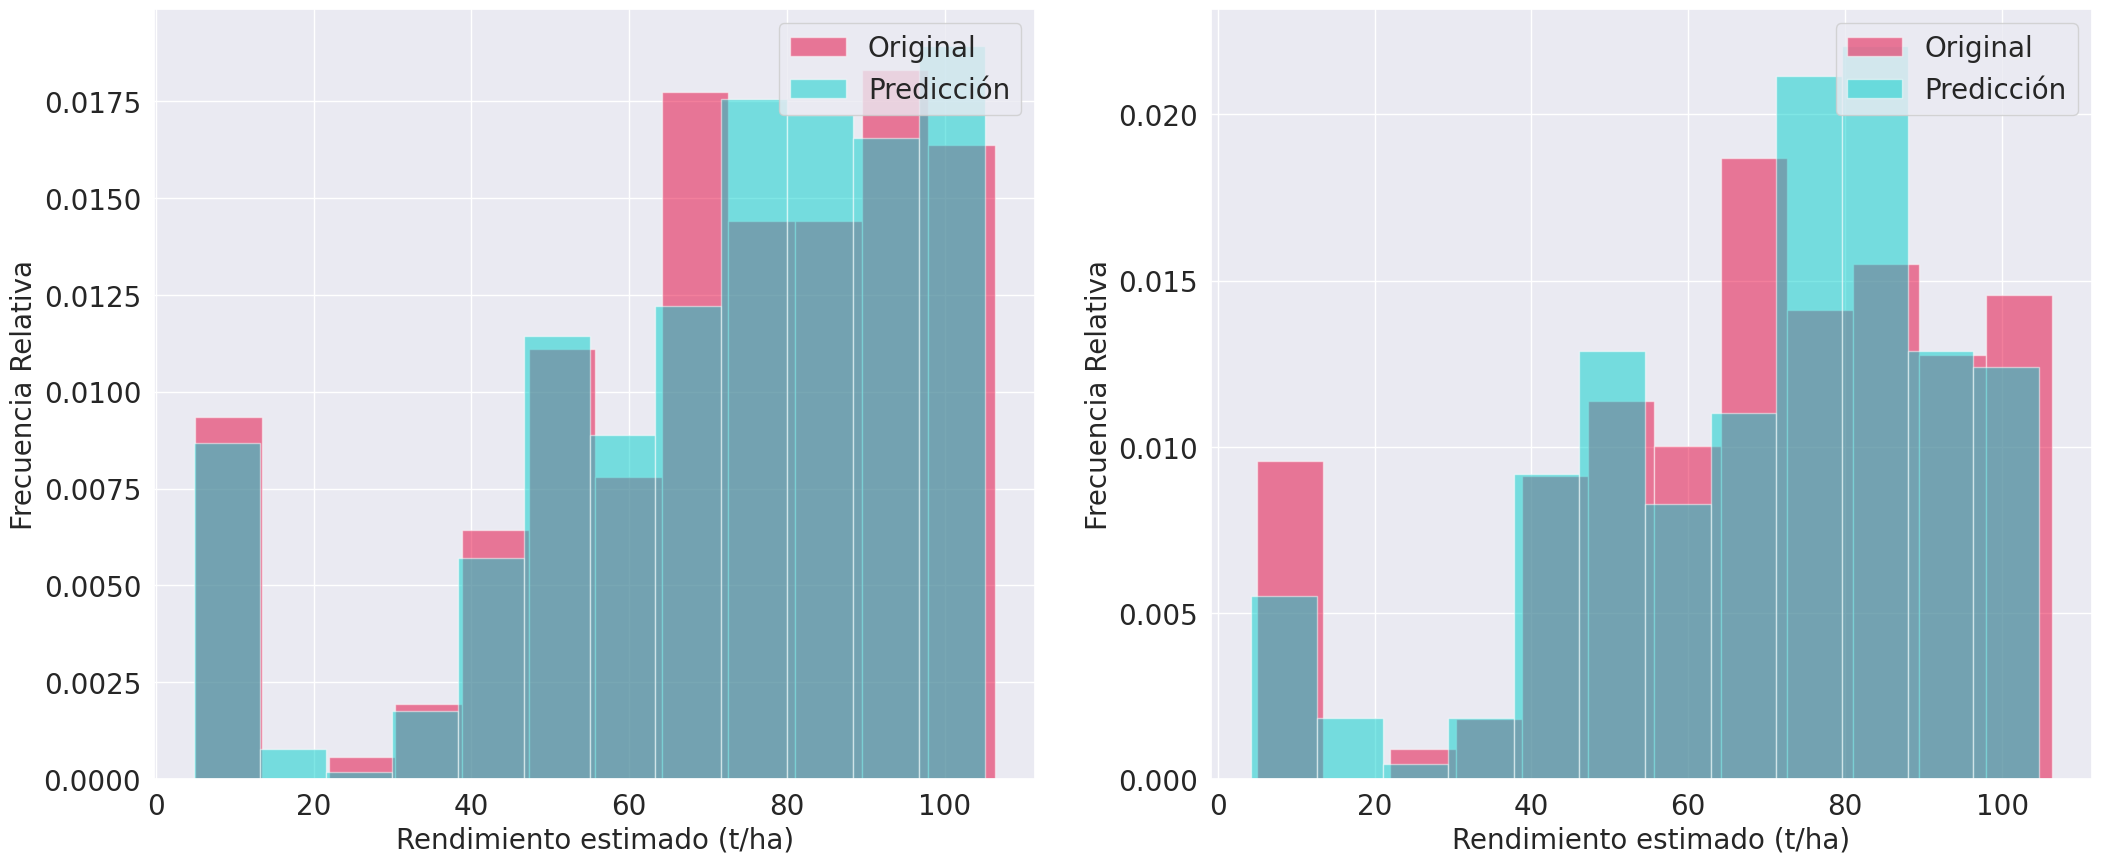

In [ ]:
# Obtener valores para graficar
if transform_target:
  target_train_orig = np.expm1(y_train)
  target_test_orig = np.expm1(y_test)

  target_train_pred = np.expm1(ypred_train)
  target_test_pred = np.expm1(ypred_test)
else:
  target_train_orig = y_train
  target_test_orig = y_test

  target_train_pred = ypred_train
  target_test_pred = ypred_test

# Visualización de resultados
f, axs = plt.subplots(1,1,figsize=(25,10))
axs.tick_params(axis='both', labelsize=20)

plt.subplot(1, 2, 1)
plt.hist(target_train_orig[target_train_orig>5],alpha = 0.5, label='Original', density=True, bins = 12, color=color_pal[1])
plt.hist(target_train_pred[target_train_orig>5],alpha = 0.5, label='Predicción', density=True, bins = 12, color = color_pal[0])
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=20)
plt.ylabel('Frecuencia Relativa', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
#plt.title(r'Histograma de datos de entrenamiento (Train)', fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.subplot(1, 2, 2)
plt.hist(target_test_orig[target_test_orig>5],alpha = 0.5, label='Original', density=True, bins = 12, color=color_pal[1])
plt.hist(target_test_pred[target_test_orig>5],alpha = 0.5, label='Predicción', density=True, bins = 12, color = color_pal[0])
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=20)
plt.ylabel('Frecuencia Relativa', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
#plt.title(r'Histograma de datos de prueba (Test)', fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

In [ ]:
# Definir métricas en un dataframe
metrics_rf = {'metric_name':  ['RMSE', 'RMSE', 'NRMSE', 'NRMSE', 'R-cuadrado', 'R-cuadrado'],
           'set_used': ['Train', 'Test', 'Train', 'Test', 'Train', 'Test'],
           'metric_value': [rmse_train, rmse_test
           ,nrmse_train, nrmse_test
           ,r2_train, r2_test]
        }

metrics_rf = pd.DataFrame(metrics_rf, columns = ['metric_name', 'set_used','metric_value'])

# Graficos de las métricas
fig = go.Figure(data=[
    go.Bar(name='Entrenamiento', x=metrics_rf[metrics_rf['set_used']=="Train"]['metric_name'], y=metrics_rf[metrics_rf['set_used']=="Train"]['metric_value'], marker_color=color_pal[2]),
    go.Bar(name='Prueba', x=metrics_rf[metrics_rf['set_used']=="Test"]['metric_name'], y=metrics_rf[metrics_rf['set_used']=="Test"]['metric_value'], marker_color=color_pal[3]),
], layout_yaxis_range=[0,metrics_rf['metric_value'].max()+1])

# Agregar una línea discontinua horizontal en y=1
fig.add_shape(
    type='line',
    x0=-0.5,  # Comienza justo antes de la primera barra
    x1=len(metrics_rf['metric_name'].unique()) - 0.5,  # Termina justo después de la última barra
    y0=1,
    y1=1,
    line=dict(color='Black', width=2, dash='dash')  # Personaliza el color, el ancho y el estilo de la línea
)

fig.update_layout(barmode='group', autosize=False,
    width=700,
    height=500, xaxis_title="Métricas",
    yaxis_title="Valor de evaluación",
    legend_title="Datos", font=dict(size=16)
    )

fig.show()

# Guardar tiempo de entrenamiento en un dataframe
time_measure_rf = {'measure_name':  ['Time'],
           'measure_value': [training_time]
        }

time_measure_rf = pd.DataFrame(time_measure_rf, columns = ['measure_name','measure_value'])

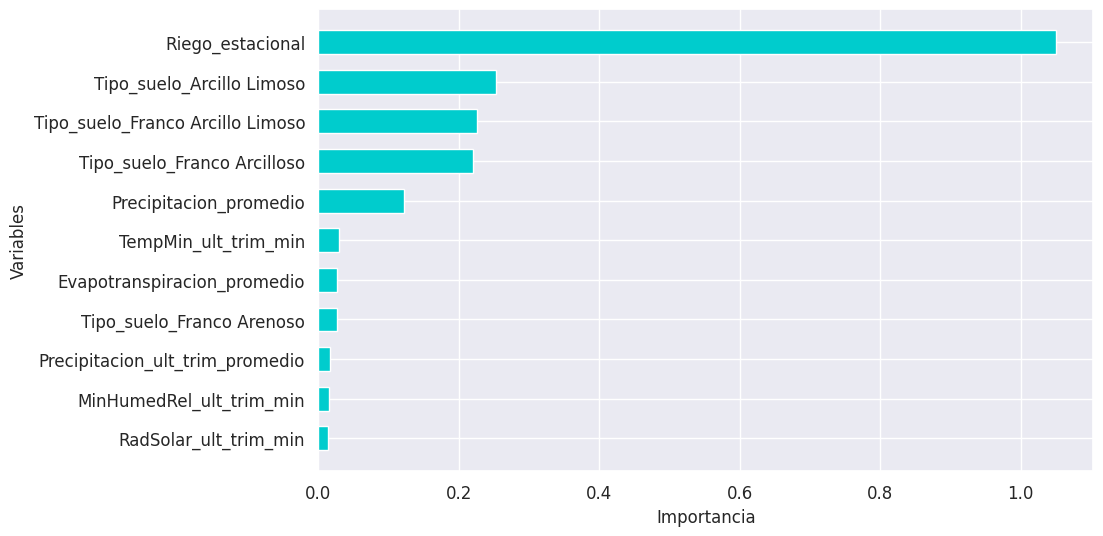

In [ ]:
# Ordenar el dataframe por valores de importancia en orden descendente
rf_importance = importance.copy()

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(rf_importance['Variable'], rf_importance['Importancia'], color=color_pal[3], height=0.6)
plt.xlabel('Importancia', fontsize = 12)
plt.ylabel('Variables', fontsize = 12)
#plt.title('Random Forest', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.gca().invert_yaxis()  # Invierta el eje y para mostrar la mayor importancia en la parte superior
plt.show()

# Explicabilidad de las variables (Interpretabilidad)

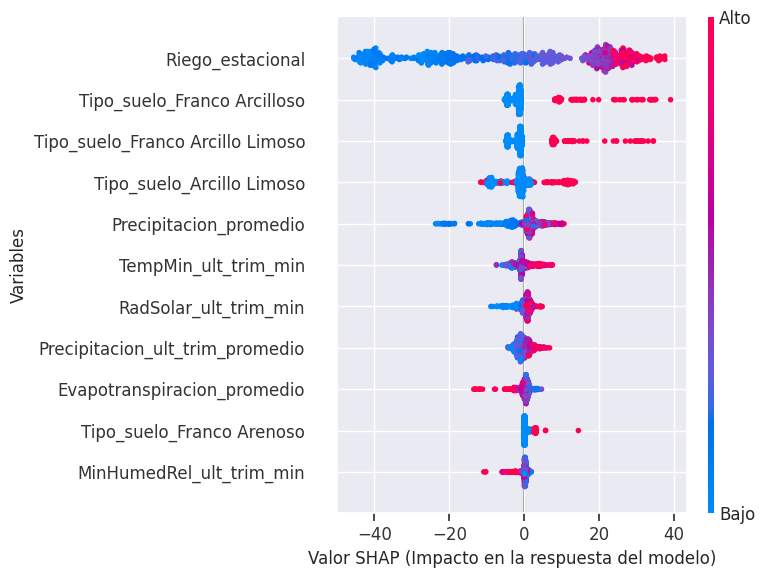

In [ ]:
# Definir objeto SHAP
explainer = shap.TreeExplainer(rf_grid.named_steps['randomforestregressor'])
shap_values = explainer.shap_values(x_train)

# Graficar efecto de las variables
shap.summary_plot(shap_values, x_train, show=False)

# Obtener la figura y los ejes actuales
fig = plt.gcf()
ax = plt.gca()

# Personalizar las etiquetas de los ejes
if len(fig.axes) > 1:
    cbar_ax = fig.axes[-1]
    cbar_ax.set_ylabel('', rotation=90, labelpad=20)
    cbar_ax.set_yticklabels(['Bajo', 'Alto'], fontsize=12)

# Modificar los ejes
ax.set_xlabel('Valor SHAP (Impacto en la respuesta del modelo)', fontsize=12)
ax.set_ylabel('Variables', fontsize=12)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Mostrar el gráfico
plt.show()

In [ ]:
# Extraer el modelo RandomForest entrenado
rforest_model = rf_grid.named_steps['randomforestregressor']

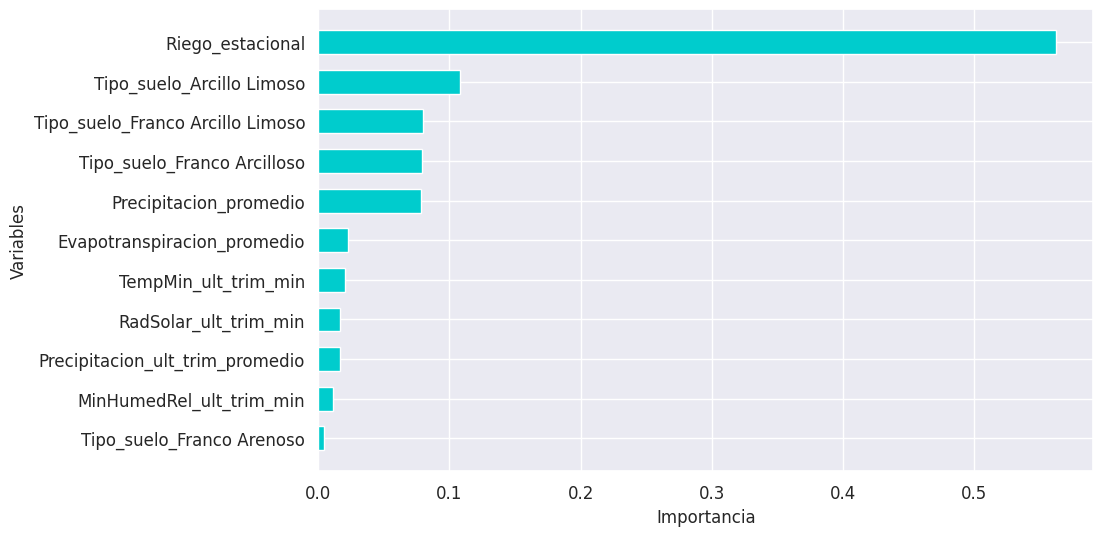

In [ ]:
# Importancia propia del algoritmo
importances = rforest_model.feature_importances_

# Ordenar la importancia en orden descendente
indices = np.argsort(importances)[-20:]

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align="center", color=color_pal[3], height=0.6)
plt.xlabel("Importancia", fontsize = 12)
plt.ylabel("Variables", fontsize = 12)
#plt.title("Random Forest")
plt.xticks(fontsize = 12)
plt.yticks(range(len(indices)), [cols_rf[i] for i in indices], fontsize = 12)
plt.show()

# Applying Catboost technique

In [ ]:
# cols_cb = ['Riego_estacional',
#            'TempMin_min', 'TempMax_min',
#            'Evapotranspiracion_min', 'MinHumedRel_min', 'MaxHumedRel_min', 'RadSolar_min',
#            'TempMin_max', 'TempMax_max',
#            'Precipitacion_max', 'Evapotranspiracion_max', 'MinHumedRel_max', 'RadSolar_max',
#            'TempMin_promedio', 'TempMax_promedio', 'Precipitacion_promedio', 'Evapotranspiracion_promedio',
#            'MinHumedRel_promedio', 'MaxHumedRel_promedio', 'RadSolar_promedio',
#            'TempMin_ult_trim_min', 'TempMax_ult_trim_min',
#            'Evapotranspiracion_ult_trim_min', 'MinHumedRel_ult_trim_min', 'MaxHumedRel_ult_trim_min', 'RadSolar_ult_trim_min',
#            'TempMin_ult_trim_max',
#            'TempMax_ult_trim_max',
#            'Precipitacion_ult_trim_max', 'Evapotranspiracion_ult_trim_max', 'MinHumedRel_ult_trim_max', 'RadSolar_ult_trim_max',
#            'TempMin_ult_trim_promedio', 'TempMax_ult_trim_promedio',
#            'Precipitacion_ult_trim_promedio', 'Evapotranspiracion_ult_trim_promedio',
#            'MinHumedRel_ult_trim_promedio', 'MaxHumedRel_ult_trim_promedio', 'RadSolar_ult_trim_promedio',
#            'Tipo_suelo_Arcillo Limoso', 'Tipo_suelo_Franco Arcillo Limoso', 'Tipo_suelo_Franco Arcilloso', 'Tipo_suelo_Franco Arenoso']

In [ ]:
# Selección de variables finales

cols_cb = [
'Riego_estacional',
'Tipo_suelo_Franco Arcilloso',
'Tipo_suelo_Franco Arcillo Limoso',
'Tipo_suelo_Arcillo Limoso',
'Precipitacion_promedio',
'Precipitacion_ult_trim_promedio',
'TempMin_ult_trim_min',
'Evapotranspiracion_promedio',
'Tipo_suelo_Franco Arenoso'
]

In [ ]:
# Filtrar los datasets con las covariables seleccionadas
x_train = x_train_tot[cols_cb]
x_test = x_test_tot[cols_cb]

In [ ]:
# Ajustar indicador para entrenar o cargar modelo
# Para cargar un modelo: load_model = True
# Para entrenar un modelo: load_model = False
load_model = False

print("======================================================================================")
print("X Train dimensión:",x_train.shape)
print("Y Train dimensión:",y_train.shape)
print("X Test dimensión:",x_test.shape)
print("Y Test dimensión:",y_test.shape)

# Imprimir hiperparámetros óptimos
if load_model:
  # Cargar modelo
  infile = open(models_path + '/CatBoost_model.pkl','rb')
  cat_model_f = pickle.load(infile)
  infile = open(models_path + '/params_CatBoost_model.pkl','rb')
  best_params = pickle.load(infile)
  infile = open(models_path + '/train_time_model_CatBoost.pkl','rb')
  training_time = pickle.load(infile)
else:
  start_time = time.time()
  # Definir función a minimizar
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):

      # Usar parámetros para entrenar el modelo
      model = make_pipeline( CatBoostRegressor(random_state = random_state, **params))

      # Validación cruzada
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Definir grilla
  # parameters = {'iterations': hp.choice('iterations', [1000,6000])
  parameters = {'iterations': hp.choice('iterations', [250,100,500,1000, 2000])
        , 'eval_metric': hp.choice('eval_metric', ['RMSE'])
        , 'early_stopping_rounds': hp.choice('early_stopping_rounds', [200])
        , 'learning_rate': hp.choice('learning_rate', [0.05, 0.005, 0.0005])
        , 'l2_leaf_reg': hp.choice('l2_leaf_reg', [1, 3, 5, 9])
        # , 'depth': hp.choice('depth', [4, 6, 10])
    }

  # Minimizar función
  best = fmin(fn = param_selection_cv
            , space = parameters
            , algo = tpe.suggest
            , max_evals = 10
            , rstate = np.random.default_rng(random_state)
          )

  # Devuelve los mejores hiperparámetros
  best_params = space_eval(parameters, best)

  # Definir modelo con los mejores hiperparámetros
  cat_f = make_pipeline( CatBoostRegressor(random_state = random_state, **best_params))

  # Entrenar modelo
  cat_model_f = cat_f.fit(x_train,y_train)

  # Obtener tiempo total de entrenamiento
  training_time = time.time() - start_time

  # Guardar modelo
  with open(models_path + '/CatBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(cat_model_f, pickfile)
  with open(models_path + '/params_CatBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
  with open(models_path + '/train_time_model_CatBoost.pkl', 'wb') as pickfile:
    pickle.dump(training_time, pickfile)

print("======================================================================================")
print("Mejores parámetros: ")
print(best_params)
print("======================================================================================")

# Predecir valores de regresión con train
ypred_train = cat_model_f.predict(x_train)

# Predecir valores de regresión con test
ypred_test = cat_model_f.predict(x_test)

# Evaluador para NRMSE (Error cuadrático medio normalizado)
evaluator_train = RegressionMetric(list(y_train), list(ypred_train))
evaluator_test = RegressionMetric(list(y_test), list(ypred_test))

# Obtener las métricas de evaluación (RMSE, NRMSE, R2) por cada dataset
rmse_train, nrmse_train, r2_train = rmse(y_train, ypred_train), evaluator_train.normalized_root_mean_square_error(), r2_score(y_train, ypred_train)
rmse_test, nrmse_test, r2_test = rmse(y_test, ypred_test), evaluator_test.normalized_root_mean_square_error(), r2_score(y_test, ypred_test)

print("\n\nRESULTADOS FINALES: ===========================================================================================================================================================================================")
print('Train: RMSE: {:} | NRMSE: {} | R-cuadrado: {}'.format(rmse_train, nrmse_train, r2_train))
print('Test: RMSE: {:} | NRMSE: {} | R-cuadrado: {}'.format(rmse_test, nrmse_test, r2_test))
print("Tiempo de entrenamiento: %s segundos" % (training_time))

# Cálculo de la importancia de las covariables
imps = permutation_importance(cat_model_f, x_train, y_train)

# Crear dataframe con la importancia de las covariables
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["Variable","Importancia"]

importance = importance.sort_values(by='Importancia', ascending=False)
print("======================================================================================")
print("Importancia de las variables:")
print(importance)

X Train dimensión: (700, 9)
Y Train dimensión: (700,)
X Test dimensión: (300, 9)
Y Test dimensión: (300,)
100%|██████████| 10/10 [00:42<00:00,  4.30s/trial, best loss: 4.632186715198122]
0:	learn: 32.6555613	total: 48.7ms	remaining: 1m 37s
1:	learn: 31.6079021	total: 50.5ms	remaining: 50.4s
2:	learn: 30.8656310	total: 55.5ms	remaining: 36.9s
3:	learn: 29.8304094	total: 57.3ms	remaining: 28.6s
4:	learn: 28.7815130	total: 64.7ms	remaining: 25.8s
5:	learn: 28.0927792	total: 69.1ms	remaining: 23s
6:	learn: 27.0541871	total: 72ms	remaining: 20.5s
7:	learn: 26.2959479	total: 79.2ms	remaining: 19.7s
8:	learn: 25.6190686	total: 84.6ms	remaining: 18.7s
9:	learn: 24.9330711	total: 90.5ms	remaining: 18s
10:	learn: 24.0120516	total: 95.9ms	remaining: 17.3s
11:	learn: 23.5505400	total: 97.2ms	remaining: 16.1s
12:	learn: 22.6565394	total: 98.9ms	remaining: 15.1s
13:	learn: 21.8338666	total: 100ms	remaining: 14.2s
14:	learn: 21.0666719	total: 102ms	remaining: 13.5s
15:	learn: 20.5791636	total: 103ms	

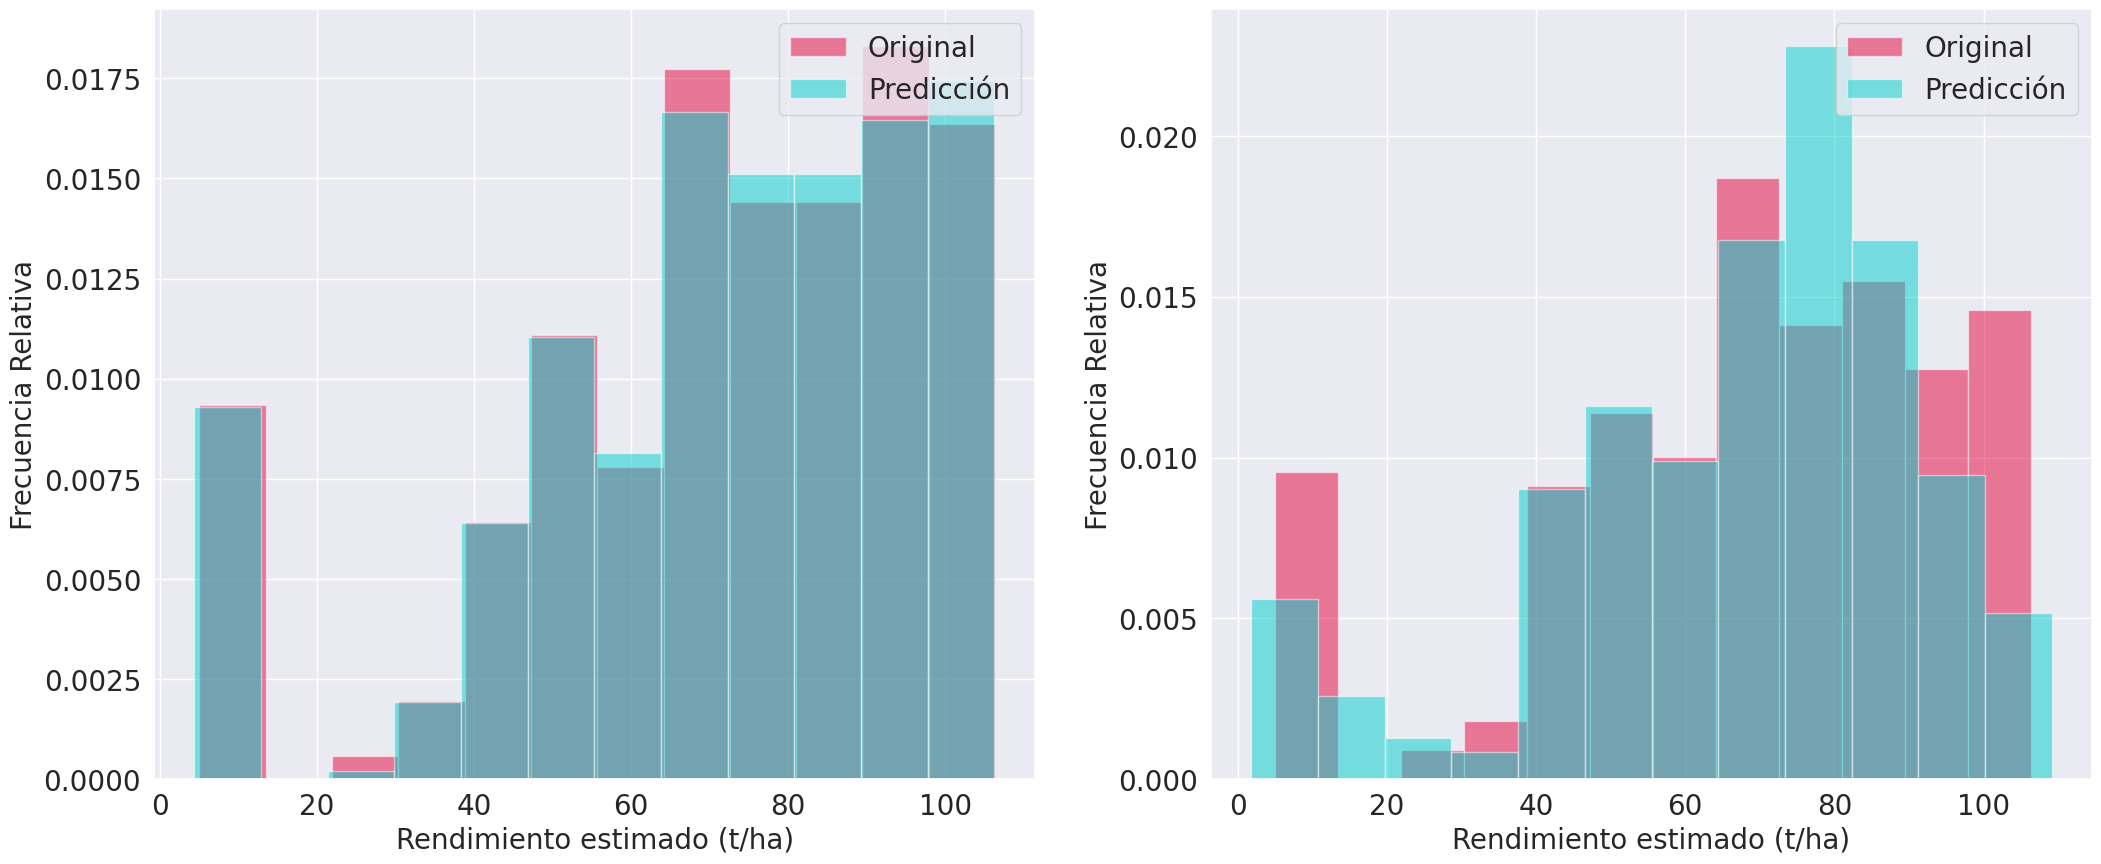

In [ ]:
# Obtener valores para graficar
if transform_target:
  target_train_orig = np.expm1(y_train)
  target_test_orig = np.expm1(y_test)

  target_train_pred = np.expm1(ypred_train)
  target_test_pred = np.expm1(ypred_test)
else:
  target_train_orig = y_train
  target_test_orig = y_test

  target_train_pred = ypred_train
  target_test_pred = ypred_test

# Visualización de resultados
f, axs = plt.subplots(1,1,figsize=(25,10))
axs.tick_params(axis='both', labelsize=20)

plt.subplot(1, 2, 1)
plt.hist(target_train_orig[target_train_orig>5],alpha = 0.5, label='Original', density=True, bins = 12, color=color_pal[1])
plt.hist(target_train_pred[target_train_orig>5],alpha = 0.5, label='Predicción', density=True, bins = 12, color = color_pal[0])
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=20)
plt.ylabel('Frecuencia Relativa', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
#plt.title(r'Histograma de datos de entrenamiento (Train)', fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.subplot(1, 2, 2)
plt.hist(target_test_orig[target_test_orig>5],alpha = 0.5, label='Original', density=True, bins = 12, color=color_pal[1])
plt.hist(target_test_pred[target_test_orig>5],alpha = 0.5, label='Predicción', density=True, bins = 12, color = color_pal[0])
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=20)
plt.ylabel('Frecuencia Relativa', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
#plt.title(r'Histograma de datos de prueba (Test)', fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

In [ ]:
# Definir métricas en un dataframe
metrics_catboost = {'metric_name':  ['RMSE', 'RMSE', 'NRMSE', 'NRMSE', 'R-cuadrado', 'R-cuadrado'],
           'set_used': ['Train', 'Test', 'Train', 'Test', 'Train', 'Test'],
           'metric_value': [rmse_train, rmse_test
           ,nrmse_train, nrmse_test
           ,r2_train, r2_test]
        }

metrics_catboost = pd.DataFrame(metrics_catboost, columns = ['metric_name', 'set_used','metric_value'])

# Graficos de las métricas
fig = go.Figure(data=[
    go.Bar(name='Entrenamiento', x=metrics_catboost[metrics_catboost['set_used']=="Train"]['metric_name'], y=metrics_catboost[metrics_catboost['set_used']=="Train"]['metric_value'], marker_color=color_pal[2]),
    go.Bar(name='Prueba', x=metrics_catboost[metrics_catboost['set_used']=="Test"]['metric_name'], y=metrics_catboost[metrics_catboost['set_used']=="Test"]['metric_value'], marker_color=color_pal[3]),
], layout_yaxis_range=[0,metrics_catboost['metric_value'].max()+1])

# Agregar una línea discontinua horizontal en y=1
fig.add_shape(
    type='line',
    x0=-0.5,  # Comienza justo antes de la primera barra
    x1=len(metrics_catboost['metric_name'].unique()) - 0.5,  # Termina justo después de la última barra
    y0=1,
    y1=1,
    line=dict(color='Black', width=2, dash='dash')  # Personaliza el color, el ancho y el estilo de la línea
)

fig.update_layout(barmode='group', autosize=False,
    width=700,
    height=500, xaxis_title="Métricas",
    yaxis_title="Valor de evaluación",
    legend_title="Datos", font=dict(size=16)
    )

fig.show()

# Guardar tiempo de entrenamiento en un dataframe
time_measure_catboost = {'measure_name':  ['Time'],
           'measure_value': [training_time]
        }

time_measure_catboost = pd.DataFrame(time_measure_catboost, columns = ['measure_name','measure_value'])

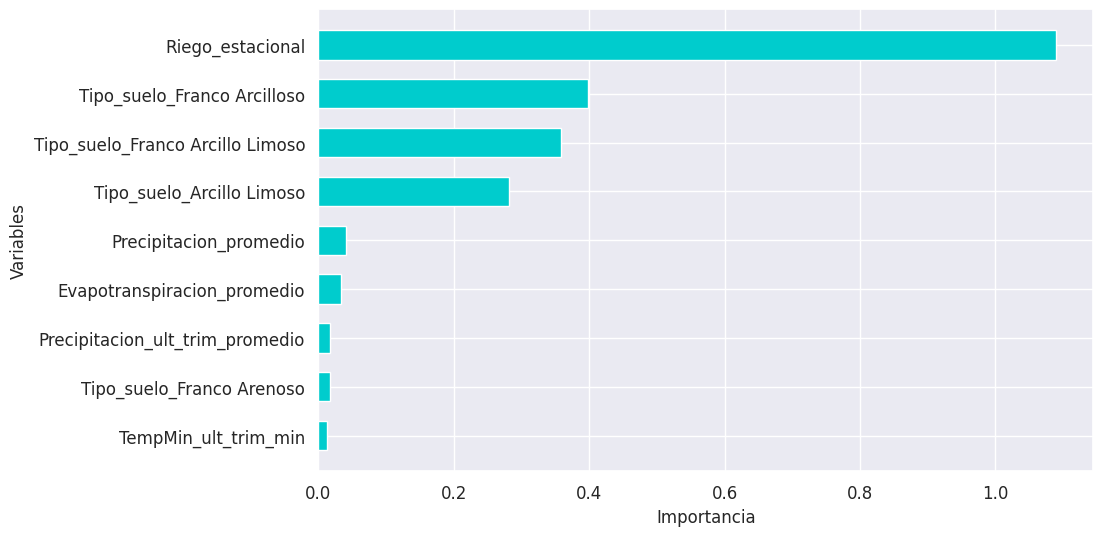

In [ ]:
# Ordenar el dataframe por valores de importancia en orden descendente
cb_importance = importance.copy()

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(cb_importance['Variable'], cb_importance['Importancia'], color=color_pal[3], height=0.6)
plt.xlabel('Importancia', fontsize = 12)
plt.ylabel('Variables', fontsize = 12)
#plt.title('CatBoost', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.gca().invert_yaxis()  # Invierta el eje y para mostrar la mayor importancia en la parte superior
plt.show()

# Explicabilidad de las variables (Interpretabilidad)

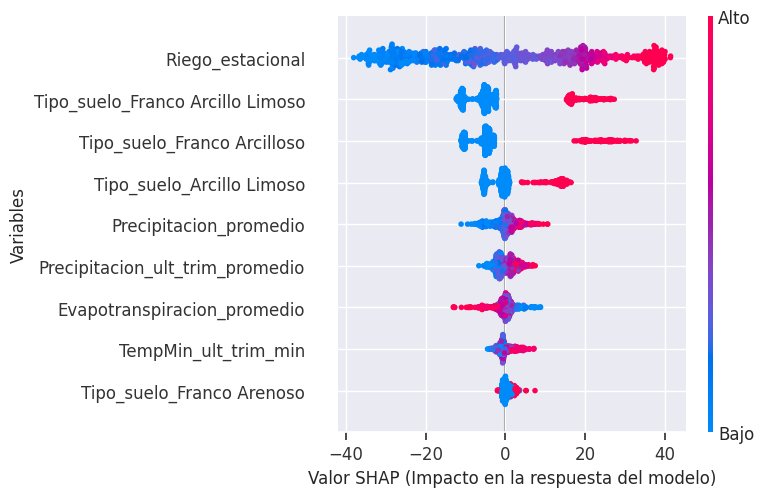

In [ ]:
# Definir objeto SHAP
explainer = shap.TreeExplainer(cat_model_f.named_steps['catboostregressor'])
shap_values = explainer.shap_values(x_train)

# Graficar efecto de las variables
shap.summary_plot(shap_values, x_train, show=False)

# Obtener la figura y los ejes actuales
fig = plt.gcf()
ax = plt.gca()

# Personalizar las etiquetas de los ejes
if len(fig.axes) > 1:
    cbar_ax = fig.axes[-1]
    cbar_ax.set_ylabel('', rotation=90, labelpad=20)
    cbar_ax.set_yticklabels(['Bajo', 'Alto'], fontsize=12)

# Modificar los ejes
ax.set_xlabel('Valor SHAP (Impacto en la respuesta del modelo)', fontsize=12)
ax.set_ylabel('Variables', fontsize=12)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Mostrar el gráfico
plt.show()

In [ ]:
# Extraer el modelo CatBoost entrenado
catboost_model = cat_model_f.named_steps['catboostregressor']

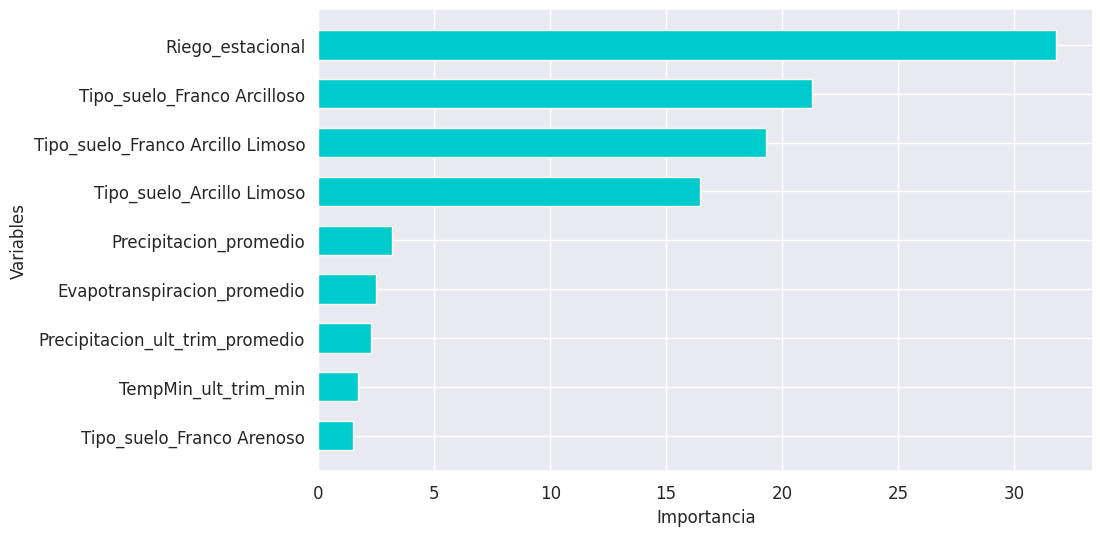

In [ ]:
# Importancia propia del algoritmo
importances = catboost_model.get_feature_importance()

# Ordenar la importancia en orden descendente
indices = np.argsort(importances)[-20:]

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align="center", color=color_pal[3], height=0.6)
plt.xlabel("Importancia", fontsize = 12)
plt.ylabel("Variables", fontsize = 12)
#plt.title("CatBoost", fontsize = 1)
plt.xticks(fontsize = 12)
plt.yticks(range(len(indices)), [cols_cb[i] for i in indices], fontsize = 12)
plt.show()

# Aplicación de la técnica de regresión Elastic net



In [ ]:
cols_en = ['Riego_estacional',
           'TempMin_min', 'TempMax_min',
           'Evapotranspiracion_min', 'MinHumedRel_min', 'MaxHumedRel_min', 'RadSolar_min',
           'TempMin_max', 'TempMax_max',
           'Precipitacion_max', 'Evapotranspiracion_max', 'MinHumedRel_max', 'RadSolar_max',
           'TempMin_promedio', 'TempMax_promedio', 'Precipitacion_promedio', 'Evapotranspiracion_promedio',
           'MinHumedRel_promedio', 'MaxHumedRel_promedio', 'RadSolar_promedio',
           'TempMin_ult_trim_min', 'TempMax_ult_trim_min',
           'Evapotranspiracion_ult_trim_min', 'MinHumedRel_ult_trim_min', 'MaxHumedRel_ult_trim_min', 'RadSolar_ult_trim_min',
           'TempMin_ult_trim_max',
           'TempMax_ult_trim_max',
           'Precipitacion_ult_trim_max', 'Evapotranspiracion_ult_trim_max', 'MinHumedRel_ult_trim_max', 'RadSolar_ult_trim_max',
           'TempMin_ult_trim_promedio', 'TempMax_ult_trim_promedio',
           'Precipitacion_ult_trim_promedio', 'Evapotranspiracion_ult_trim_promedio',
           'MinHumedRel_ult_trim_promedio', 'MaxHumedRel_ult_trim_promedio', 'RadSolar_ult_trim_promedio',
           'Tipo_suelo_Arcillo Limoso', 'Tipo_suelo_Franco Arcillo Limoso', 'Tipo_suelo_Franco Arcilloso', 'Tipo_suelo_Franco Arenoso']

In [ ]:
# Selección de variables finales

# cols_en = [
# 'Tipo_suelo_Franco Arcillo Limoso',
# 'Riego_estacional',
# 'Tipo_suelo_Franco Arcilloso',
# 'Tipo_suelo_Arcillo Limoso',
# 'Tipo_suelo_Franco Arenoso',
# 'Evapotranspiracion_promedio',
# 'Evapotranspiracion_ult_trim_promedio',
# 'Precipitacion_promedio'
# ]

In [ ]:
# Filtrar los datasets con las covariables seleccionadas
x_train = x_train_tot[cols_en]
x_test = x_test_tot[cols_en]

In [ ]:
# Ajustar indicador para entrenar o cargar modelo
# Para cargar un modelo: load_model = True
# Para entrenar un modelo: load_model = False
load_model = False

print("======================================================================================")
print("X Train dimensión:",x_train.shape)
print("Y Train dimensión:",y_train.shape)
print("X Test dimensión:",x_test.shape)
print("Y Test dimensión:",y_test.shape)

# Imprimir hiperparámetros óptimos
if load_model:
  # Cargar modelo
  infile = open(models_path + '/elasticnet_model.pkl','rb')
  elasticnet_grid = pickle.load(infile)
  infile = open(models_path + '/train_time_model_elasticnet.pkl','rb')
  training_time = pickle.load(infile)
else:
  start_time = time.time()

  # Definir objeto elasticnet
  elasticnet = ElasticNet(random_state=12345)

  # Definir grilla
  parameters = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
                ,'l1_ratio': np.arange(0, 1, 0.01)}

  # Búsqueda aleatoria de parámetros, utilizando validación cruzada de 5 folds, búsqueda en 100 combinaciones diferentes y uso de todos los núcleos disponibles
  elasticnet_grid = RandomizedSearchCV(estimator = elasticnet, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state , n_jobs = -1)

  # Entrenar modelo
  elasticnet_grid.fit(x_train, y_train)

  # Obtener tiempo total de entrenamiento
  training_time = time.time() - start_time

  # Guardar modelo
  with open(models_path + '/elasticnet_model.pkl', 'wb') as pickfile:
     pickle.dump(elasticnet_grid, pickfile)
  with open(models_path + '/train_time_model_elasticnet.pkl', 'wb') as pickfile:
    pickle.dump(training_time, pickfile)

print("======================================================================================")
print("Mejores parámetros: ")
print(elasticnet_grid.best_params_)
print("======================================================================================")

# Predecir valores de regresión con train
ypred_train = elasticnet_grid.best_estimator_.predict(x_train)

# Predecir valores de regresión con test
ypred_test = elasticnet_grid.best_estimator_.predict(x_test)

# Evaluador para NRMSE (Error cuadrático medio normalizado)
evaluator_train = RegressionMetric(list(y_train), list(ypred_train))
evaluator_test = RegressionMetric(list(y_test), list(ypred_test))

# Obtener las métricas de evaluación (RMSE, NRMSE, R2) por cada dataset
rmse_train, nrmse_train, r2_train = rmse(y_train, ypred_train), evaluator_train.normalized_root_mean_square_error(), r2_score(y_train, ypred_train)
rmse_test, nrmse_test, r2_test = rmse(y_test, ypred_test), evaluator_test.normalized_root_mean_square_error(), r2_score(y_test, ypred_test)

print("\n\nRESULTADOS FINALES: ===========================================================================================================================================================================================")
print('Train: RMSE: {:} | NRMSE: {} | R-cuadrado: {}'.format(rmse_train, nrmse_train, r2_train))
print('Test: RMSE: {:} | NRMSE: {} | R-cuadrado: {}'.format(rmse_test, nrmse_test, r2_test))
print("Tiempo de entrenamiento: %s segundos" % (training_time))

# Cálculo de la importancia de las covariables
imps = permutation_importance(elasticnet_grid.best_estimator_, x_train, y_train)

# Crear dataframe con la importancia de las covariables
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["Variable","Importancia"]

importance = importance.sort_values(by='Importancia', ascending=False)
print("======================================================================================")
print("Importancia de las variables:")
print(importance)

X Train dimensión: (700, 43)
Y Train dimensión: (700,)
X Test dimensión: (300, 43)
Y Test dimensión: (300,)
Mejores parámetros: 
{'l1_ratio': 0.71, 'alpha': 0.001}


RESULTADOS FINALES: ===========================================================================================================================================================================================
Train: RMSE: 5.209440417434039 | NRMSE: 0.15778495510264628 | R-cuadrado: 0.9757431751787099
Test: RMSE: 13.18873532407173 | NRMSE: 0.41396707140546846 | R-cuadrado: 0.8388361825192138
Tiempo de entrenamiento: 0.8220775127410889 segundos
Importancia de las variables:
                                Variable  Importancia
40      Tipo_suelo_Franco Arcillo Limoso     1.139133
0                       Riego_estacional     1.110163
41           Tipo_suelo_Franco Arcilloso     1.104046
39             Tipo_suelo_Arcillo Limoso     0.540735
42             Tipo_suelo_Franco Arenoso     0.104237
16           Evapotranspiracion_pr

In [ ]:
# El mejor modelo
best_model = elasticnet_grid.best_estimator_

# Obtener coeficientes del mejor modelo
coefficients = best_model.coef_
intercept = best_model.intercept_

# Coeficientes del mejor modelo
coef_dict_baseline = {}
for coef, feat in zip(best_model.coef_,cols_en):
 coef_dict_baseline[feat] = coef
coef_dict_baseline

{'Riego_estacional': 24.846680856825895,
 'TempMin_min': -2.587003265609567,
 'TempMax_min': 1.4391068226630497,
 'Evapotranspiracion_min': 0.6336169066558391,
 'MinHumedRel_min': -1.2625094795981282,
 'MaxHumedRel_min': 0.2234489966140483,
 'RadSolar_min': -1.0429144974333688,
 'TempMin_max': 0.4617235381343098,
 'TempMax_max': 0.3238668011171733,
 'Precipitacion_max': 0.42901174045183,
 'Evapotranspiracion_max': -2.3938556526369785,
 'MinHumedRel_max': 0.777372664089631,
 'RadSolar_max': 0.38164311770485837,
 'TempMin_promedio': 1.5163662773366573,
 'TempMax_promedio': -3.5098617023052685,
 'Precipitacion_promedio': 3.34311752632092,
 'Evapotranspiracion_promedio': -6.897722345276357,
 'MinHumedRel_promedio': -2.100566770696145,
 'MaxHumedRel_promedio': -1.20879991825022,
 'RadSolar_promedio': 0.42689634720863107,
 'TempMin_ult_trim_min': 1.6583902001320587,
 'TempMax_ult_trim_min': -1.2037331185000466,
 'Evapotranspiracion_ult_trim_min': 0.3763439377928536,
 'MinHumedRel_ult_trim_mi

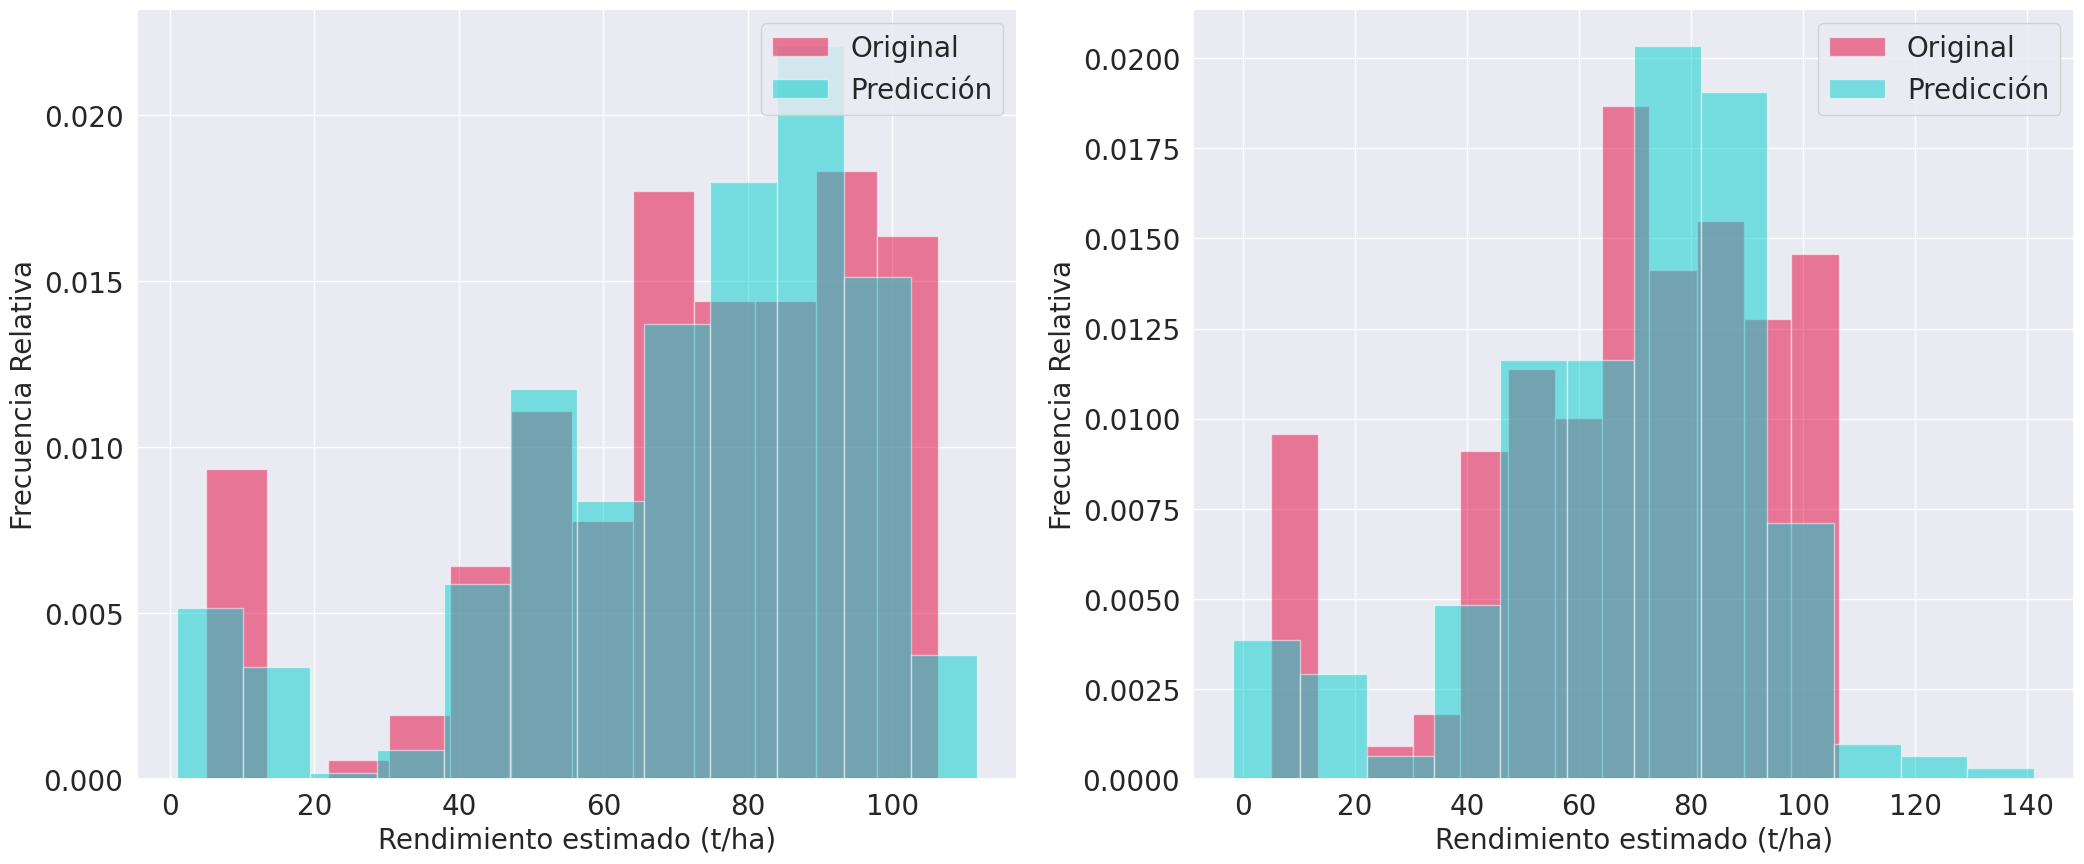

In [ ]:
# Obtener valores para graficar
if transform_target:
  target_train_orig = np.expm1(y_train)
  target_test_orig = np.expm1(y_test)

  target_train_pred = np.expm1(ypred_train)
  target_test_pred = np.expm1(ypred_test)
else:
  target_train_orig = y_train
  target_test_orig = y_test

  target_train_pred = ypred_train
  target_test_pred = ypred_test

# Visualización de resultados
f, axs = plt.subplots(1,1,figsize=(25,10))
axs.tick_params(axis='both', labelsize=20)

plt.subplot(1, 2, 1)
plt.hist(target_train_orig[target_train_orig>5],alpha = 0.5, label='Original', density=True, bins = 12, color=color_pal[1])
plt.hist(target_train_pred[target_train_orig>5],alpha = 0.5, label='Predicción', density=True, bins = 12, color = color_pal[0])
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=20)
plt.ylabel('Frecuencia Relativa', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
#plt.title(r'Histograma de datos de entrenamiento (Train)', fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.subplot(1, 2, 2)
plt.hist(target_test_orig[target_test_orig>5],alpha = 0.5, label='Original', density=True, bins = 12, color=color_pal[1])
plt.hist(target_test_pred[target_test_orig>5],alpha = 0.5, label='Predicción', density=True, bins = 12, color = color_pal[0])
plt.xlabel(target_name.replace('_', ' ') + ' (t/ha)', fontsize=20)
plt.ylabel('Frecuencia Relativa', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
#plt.title(r'Histograma de datos de prueba (Test)', fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

In [ ]:
# Definir métricas en un dataframe
metrics_enet = {'metric_name':  ['RMSE', 'RMSE', 'NRMSE', 'NRMSE', 'R-cuadrado', 'R-cuadrado'],
           'set_used': ['Train', 'Test', 'Train', 'Test', 'Train', 'Test'],
           'metric_value': [rmse_train, rmse_test
           ,nrmse_train, nrmse_test
           ,r2_train, r2_test]
        }

metrics_enet = pd.DataFrame(metrics_enet, columns = ['metric_name', 'set_used','metric_value'])

# Graficos de las métricas
fig = go.Figure(data=[
    go.Bar(name='Entrenamiento', x=metrics_enet[metrics_enet['set_used']=="Train"]['metric_name'], y=metrics_enet[metrics_enet['set_used']=="Train"]['metric_value'], marker_color=color_pal[2]),
    go.Bar(name='Prueba', x=metrics_enet[metrics_enet['set_used']=="Test"]['metric_name'], y=metrics_enet[metrics_enet['set_used']=="Test"]['metric_value'], marker_color=color_pal[3]),
], layout_yaxis_range=[0,metrics_enet['metric_value'].max()+1])

# Agregar una línea discontinua horizontal en y=1
fig.add_shape(
    type='line',
    x0=-0.5,  # Comienza justo antes de la primera barra
    x1=len(metrics_enet['metric_name'].unique()) - 0.5,  # Termina justo después de la última barra
    y0=1,
    y1=1,
    line=dict(color='Black', width=2, dash='dash')  # Personaliza el color, el ancho y el estilo de la línea
)

fig.update_layout(barmode='group', autosize=False,
    width=700,
    height=500, xaxis_title="Métricas",
    yaxis_title="Valor de evaluación",
    legend_title="Datos", font=dict(size=16)
    )

fig.show()

# Guardar tiempo de entrenamiento en un dataframe
time_measure_enet = {'measure_name':  ['Time'],
           'measure_value': [training_time]
        }

time_measure_enet = pd.DataFrame(time_measure_enet, columns = ['measure_name','measure_value'])

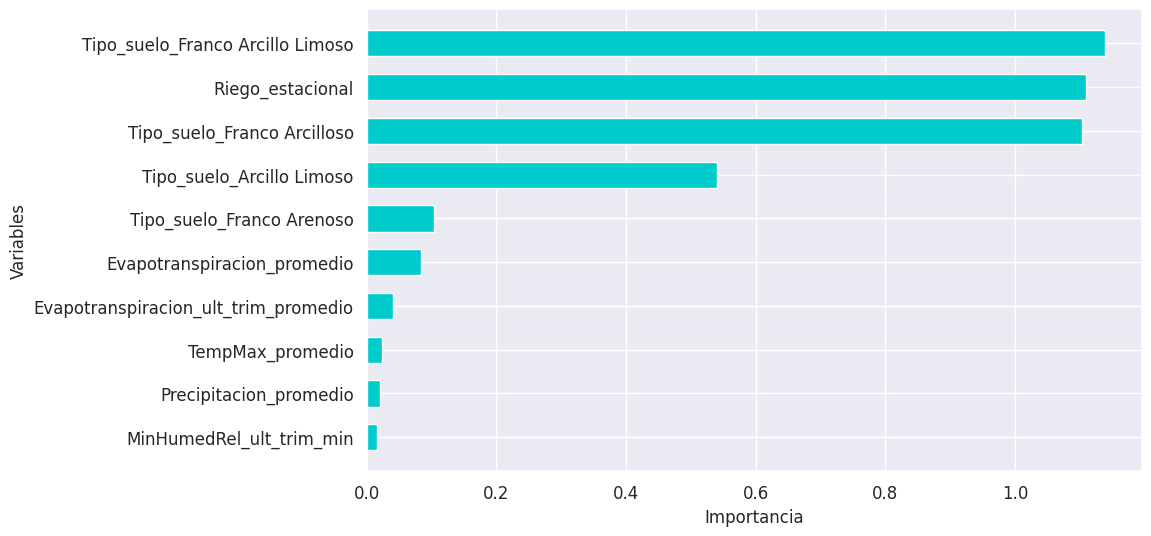

In [ ]:
# Ordenar el dataframe por valores de importancia en orden descendente
en_importance = importance.copy()

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(en_importance['Variable'][:10], en_importance['Importancia'][:10], color=color_pal[3], height=0.6)
plt.xlabel('Importancia', fontsize = 12)
plt.ylabel('Variables', fontsize = 12)
#plt.title('Elastic Net', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.gca().invert_yaxis()  # Invierta el eje y para mostrar la mayor importancia en la parte superior
plt.show()

# Comparación de métodos

In [ ]:
metric_to_compare = "R-cuadrado" # (RMSE, NRMSE, R-Squared)

# Definir la métrica general en un dataframe
compare = pd.concat([ metrics_lr[metrics_lr['metric_name'] == metric_to_compare]
                     ,metrics_xgb[metrics_xgb['metric_name'] == metric_to_compare]
                     ,metrics_rf[metrics_rf['metric_name'] == metric_to_compare]
                     ,metrics_catboost[metrics_catboost['metric_name'] == metric_to_compare]
                     ,metrics_enet[metrics_enet['metric_name'] == metric_to_compare]
                     ], axis=0, ignore_index=True)

compare['method'] = ["Regresión lineal"] * 2 + ["XGBoost"] * 2 + ["Random Forest"] * 2 + ["Catboost"] * 2 + ["Elastic Net"] * 2

# Graficar para todos los métodos
fig = go.Figure(data=[
    go.Bar(name='Entrenamiento', x=compare[compare['set_used']=="Train"]['method'], y=compare[compare['set_used']=="Train"]['metric_value'], marker_color=color_pal[2]),
    go.Bar(name='Prueba', x=compare[compare['set_used']=="Test"]['method'], y=compare[compare['set_used']=="Test"]['metric_value'], marker_color=color_pal[3]),
], layout_yaxis_range=[0,1])

fig.update_layout(barmode='group', autosize=False,
    width=1000,
    height=500, xaxis_title="Modelo entrenado",
    yaxis_title= "R-cuadrado",
    legend_title="Datos", font=dict(size=16))

fig.show()

In [ ]:
# Definir el tiempo a comparar en un dataframe
time_compare = pd.concat([ time_measure_lr
                          ,time_measure_xgb
                          ,time_measure_rf
                          ,time_measure_catboost
                          ,time_measure_enet
                     ], axis=0, ignore_index=True)

time_compare['method'] = ["Regresión lineal"] + ["XGBoost"] + ["Random Forest"] + ["Catboost"] + ["Elastic Net"]

# Graficar para todos los métodos
fig = go.Figure(data=[
    go.Bar(name='Entrenamiento', x=time_compare['method'], y=time_compare['measure_value'] / 60, marker_color=color_pal[3]),
]
, layout_yaxis_range=[0,2.5]
)

fig.update_layout(barmode='group', autosize=False,
    width=700,
    height=500, xaxis_title="Modelo entrenado",
    yaxis_title= "Tiempo de ejecución (mins)",
    legend_title="Datos", font=dict(size=16))

fig.show()